# **Comparison of subtypes** 

### Dependencies

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (shapiro, ttest_ind, mannwhitneyu, pearsonr)
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from scipy.stats import chi2_contingency
import matplotlib.ticker as ticker
 
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import pingouin as pg


In [2]:
# Data preparation
def format_stats(group, col):
    stats = group[col].agg(['mean', 'std', 'min', 'max'])
    return {
        'M (SD)': f"{stats['mean']:.2f} ({stats['std']:.2f})",
        'Range (Min-Max)': f"{stats['min']:.2f} to {stats['max']:.2f}"
    }

# Create the table structure
def create_descriptive_table(df, class_column, vars_to_include):
    result_data = []
    
    # Group unique classes
    class_groups = df[class_column].unique()
    
    for group_name in class_groups:
        group_data = df[df[class_column] == group_name]
        row_data = {
            'Classification': class_column,
            'Group': f"Group {group_name}",
            'n': len(group_data)
        }
        
        # Calculate stats for each variable
        for var in vars_to_include:
            stats = format_stats(group_data, var)
            row_data[f"{var} M (SD)"] = stats['M (SD)']
            row_data[f"{var} Range"] = stats['Range (Min-Max)']
        
        result_data.append(row_data)
    
    return pd.DataFrame(result_data)

# Create helper function for chi-square tests and reporting
def perform_chi_square(df, group_var, demo_var):
    """
    Perform chi-square test and return formatted results
    """
    # Create contingency table
    contingency = pd.crosstab(df[group_var], df[demo_var])
    
    # Calculate chi-square
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    # Calculate Cramer's V for effect size
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    # Calculate standardized residuals
    observed = contingency.values
    standardized_residuals = (observed - expected) / np.sqrt(expected)
    
    return {
        'contingency': contingency,
        'chi2': chi2,
        'p': p,
        'dof': dof,
        'cramers_v': cramers_v,
        'residuals': standardized_residuals
    }

# Function to create a table with demographic information
def create_demographic_table(df, stratification_methods, demographic_vars):
    """
    Creates a table with demographic counts, percentages, and chi-square results
    """
    result_tables = {}
    
    for method in stratification_methods:
        method_results = {}
        for demo in demographic_vars:
            # Get counts and percentages
            counts = pd.crosstab(df[method], df[demo])
            percentages = pd.crosstab(df[method], df[demo], normalize='index') * 100
            
            # Perform chi-square
            chi_result = perform_chi_square(df, method, demo)
            
            # Store results
            method_results[demo] = {
                'counts': counts,
                'percentages': percentages,
                'chi2': chi_result['chi2'],
                'p': chi_result['p'],
                'cramers_v': chi_result['cramers_v']
            }
        
        result_tables[method] = method_results
    
    return result_tables

# Function to generate  figures
def create_demographic_plots(df, stratification_methods, demographic_vars, filename=None):
    """
    Creates publication-ready plots for demographic variables
    """
    # Set up figure
    n_methods = len(stratification_methods)
    n_demos = len(demographic_vars)
    
    # Set up a nice color palette
    colors = sns.color_palette("Paired", max(3, max([len(df[demo].unique()) for demo in demographic_vars])))
    
    # Create figure with two rows (one for each method) and columns for each demographic
    fig, axes = plt.subplots(n_methods, n_demos, figsize=(4*n_demos, 4*n_methods))
    
    # If there's only one demo variable, wrap axes in a list
    if n_demos == 1:
        axes = np.array([axes]).reshape(n_methods, 1)
    
    for i, method in enumerate(stratification_methods):
        for j, demo in enumerate(demographic_vars):
            ax = axes[i, j]
            
            # Get chi-square results
            chi_result = perform_chi_square(df, method, demo)
            
            # Create the plot
            if demo == "NVIQ":  # Continuous variable handling
                sns.boxplot(x=method, y=demo, data=df, palette=colors[:len(df[method].unique())], ax=ax)
                # For IQ, we'd use ANOVA instead of chi-square
                # Perform ANOVA and get F-statistic and p-value


                #f_stat, p_val = sm.stats.anova_lm(sm.formula.ols(f"{demo} ~ C('{method}')", data=df).fit())['F'][0], sm.formula.anova_lm(sm.formula.ols(f"{demo} ~ C('{method}')", data=df).fit())['PR(>F)'][0]
                #ax.set_title(f"{demo} by {method}\nF={f_stat:.2f}, p={p_val:.3f}")
            else:
                # For categorical variables, normalize within each class
                # and create stacked percentage bars
                prop_data = pd.crosstab(df[method], df[demo], normalize='index')
                prop_data.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(df[demo].unique())])
                
                # Add chi-square result to title
                ax.set_title(f"{demo} by {method}\nχ²={chi_result['chi2']:.2f}, p={chi_result['p']:.3f}")
                
                # Add percentage labels to bars
                for container in ax.containers:
                    ax.bar_label(container, label_type='center', fmt='%.2f', fontsize=8)
                
                # Adjust y-axis to make room for labels
                ax.set_ylim(0, 1.1)
            
            # Formatting
            ax.set_xlabel(method)
            if j == 0:  # Only show y-label for first column
                ax.set_ylabel("Percentage" if demo != "NVIQ" else "IQ")
            else:
                ax.set_ylabel("")
            ax.legend(ncol=min(3, len(df[demo].unique())),  # Max 3 columns
                bbox_to_anchor=(0.5, -0.2),  # Below plot
                loc='upper center',
            frameon=False)
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    return fig


# Generate tables as DataFrames
def format_table_for_publication(demo_tables):
    """
    Format demographic results into publication-ready tables
    """
    publication_tables = {}
    
    for method, method_data in demo_tables.items():
        # Create a list to store rows
        rows = []
        
        for demo, demo_data in method_data.items():
            # Add header row for demographic variable
            rows.append({
                'Variable': f"**{demo}**",
                'Statistics': '',
                'Chi-square': '',
                'p-value': '',
                "Cramer's V": ''
            })
            
            # Add data rows
            counts = demo_data['counts']
            percentages = demo_data['percentages']
            
            for category in counts.columns:
                row_data = {
                    'Variable': f"  {category}",
                    'Statistics': 'n (%)',
                }
                
                # Add counts and percentages for each class
                for cls in counts.index:
                    count = counts.loc[cls, category]
                    percent = percentages.loc[cls, category]
                    row_data[f'Class {cls[-1] if cls in hc_order else cls}'] = f"{count} ({percent:.1f}%)"
                
                # Add chi-square info only for first category row
                if category == counts.columns[0]:
                    row_data['Chi-square'] = f"{demo_data['chi2']:.2f}"
                    row_data['p-value'] = f"{demo_data['p']:.3f}"
                    row_data["Cramer's V"] = f"{demo_data['cramers_v']:.3f}"
                
                rows.append(row_data)
        
        # Convert to DataFrame
        publication_tables[method] = pd.DataFrame(rows)
    
    return publication_tables

def calculate_p_values(df):
    """Calculate p-values for correlations in a dataframe, handling NAs"""
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i != j:
                # Get the columns and drop NA values for valid comparison
                col1 = df.iloc[:, i]
                col2 = df.iloc[:, j]
                
                # Create a mask of non-NA values in both columns
                valid_mask = ~(col1.isna() | col2.isna())
                
                # Only calculate correlation if we have enough valid data points
                if valid_mask.sum() > 1:  # Need at least 2 points for correlation
                    _, p_value = pearsonr(col1[valid_mask], col2[valid_mask])
                    p_values.iloc[i, j] = p_value
                else:
                    p_values.iloc[i, j] = np.nan
            else:
                p_values.iloc[i, j] = 0  # Set diagonal to 0
    return p_values

def plot_correlation_matrix(corr_matrix, p_values, title, significance_method='bold'):
    """Create correlation heatmap with highlighted significant correlations
    
    Parameters:
    -----------
    corr_matrix : pandas DataFrame
        The correlation matrix to plot
    p_values : pandas DataFrame
        Matrix of p-values corresponding to correlations
    title : str
        Title for the plot
    significance_method : str
        Method to highlight significant correlations:
        - 'bold': Use bold text for significant correlations
        - 'border': Add black border around significant cells
        - 'intense': Use more intense colors for significant correlations
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create the base heatmap
    ax = sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap="coolwarm", 
        center=0, 
        vmin=-1, 
        vmax=1, 
        square=True, 
        mask=mask,
        fmt=".2f",
        annot_kws={"size": 9}
    )
    
    # Create a custom annotation function for significant values
    #  
    if significance_method == 'bold' or significance_method == 'size':
        # Get all text elements from the heatmap
        # Create a new set of annotations for significant values
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix.columns)):
                # Only process cells in the lower triangle
                if i > j:  # Lower triangle only
                    is_significant = (not np.isnan(p_values.iloc[i, j]) and 
                                     p_values.iloc[i, j] < 0.05)
                    
                    if is_significant:
                        value = corr_matrix.iloc[i, j]
                        if significance_method == 'bold':
                            # Add a bold text annotation
                            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                                   ha='center', va='center', 
                                   fontweight='bold', color='black',
                                   fontsize=8)
                        elif significance_method == 'size':
                            # Add a larger text annotation
                            ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                                   ha='center', va='center', 
                                   color='black', fontsize=12)
    
    # Add borders for significant cells
    elif significance_method == 'border':
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix.columns)):
                if i > j:  # Lower triangle only
                    is_significant = (not np.isnan(p_values.iloc[i, j]) and 
                                     p_values.iloc[i, j] < 0.05)
                    
                    if is_significant:
                        # Add border around significant cells
                        ax.add_patch(Rectangle((j, i), 1, 1, fill=False, 
                                              edgecolor='gray', lw=2))
    
    #  
    #  
    
    # Add p-value significance legend
    legend_text = {
        'bold': "Bold values indicate p < 0.05",
        'size': "Larger values indicate p < 0.05",
        'border': "Cells with gray borders indicate p < 0.05"
    }
    plt.figtext(0.5, 0.001, legend_text.get(significance_method, 
                                          "Highlighted cells indicate p < 0.05"), 
               ha="center")
    
    plt.title(title, fontsize=14, pad=20)
    plt.tight_layout()
    
    return ax


In [3]:
# Function to perform outlier removal using IQR
def handle_outliers_iqr(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
    return df_filtered

In [4]:
# Write the date
date= "2025_04_23"
mplus_date = "May_2025"

## **Data setup:** combine LPA classes with HC classes

In [5]:
analysis_type= "5D"

In [6]:
# Lannguage variables 
language_vars = ['receptive_6', 'expressive_6', 'receptive_12',
       'expressive_12', 'receptive_18', 'expressive_18', 'receptive_24',
       'expressive_24', 'receptive_36', 'expressive_36', 'nonverbal_iq_6']
cleaned_language_vars= ['Receptive MSEL 6 months', 'Expressive MSEL 6 months',
                               
              'Receptive MSEL 12 months', 'Expressive MSEL 12 months',
              'Receptive MSEL 18 months', 'Expressive MSEL 18 months',
              'Receptive MSEL 24 months', 'Expressive MSEL 24 months',
              'Receptive MSEL 36 months', 'Expressive MSEL 36 months',
              'NVIQ']

In [7]:
# EEG variables
eeg_vars= ["auditory_con_6","lang_comp_con_6","speech_con_6_left","front_gamma_6", "gamma_lat_6"]
clean_eeg_vars= ['Frontal Gamma Power', 'Connectivity Auditory Network',
       'Connectivity Language', 'Connectivity Speech', 'Power Lateralization']

In [8]:
# Clean up column names
clean_column_name_mapping = {
  'expressive_6': 'Expressive MSEL 6 months',
  'expressive_12': 'Expressive MSEL 12 months',
  'expressive_18': 'Expressive MSEL 18 months',
  'expressive_24': 'Expressive MSEL 24 months',
  'expressive_36': 'Expressive MSEL 36 months',
  'receptive_6': 'Receptive MSEL 6 months',
  'receptive_12': 'Receptive MSEL 12 months',
  'receptive_18': 'Receptive MSEL 18 months',
  'receptive_24': 'Receptive MSEL 24 months',
  'receptive_36': 'Receptive MSEL 36 months',
  'nonverbal_iq_6': 'NVIQ',
  'outcome': 'ASD Diagnosis',
  'sex': 'Sex', 
  'site': 'Site',
  'group_type': 'ASD Likelihood',
  'gamma_lat_6': 'Power Lateralization',
  'speech_con_6_left': 'Connectivity Speech',
  'auditory_con_6': 'Connectivity Auditory Network',
  'lang_comp_con_6': 'Connectivity Language',
  'front_gamma_6': 'Frontal Gamma Power', 
  'front_alpha_6': 'Frontal Alpha Power', 
  'stg_lat_6': 'STG Lateralization',
  'lang_lat_6': 'Language Power Lateralization',
  'lpa_class': 'LPA Class',
  'hc_class': 'HC Class'
}


####  Load LPA classes

In [9]:
# Load LPA classes
LPA_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/mplus_5D_3cls_250424.csv", delim_whitespace=True, header=None)
LPA_df.columns = ["auditory_con_6","lang_comp_con_6","speech_con_6_left","front_gamma_6", "gamma_lat_6", "prob_class_1", "prob_class_2","prob_class_3","class"]
clinisubs_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/full_2025_04_23_5D.csv") 


# Make sure both neurosubs_df and clinisubs_df have the same number of rows
if len(LPA_df) == len(clinisubs_df):
    print("Both dataframes have the same number of rows")
    # Merge the two dataframes
    
    LPA_df = pd.concat([LPA_df, clinisubs_df], axis=1)

# Select only the columns we need
LPA_df["lpa_class"] = LPA_df["class"].astype(str)

LPA_df= LPA_df[["lpa_class","subject","prob_class_1", "prob_class_2", "prob_class_3"]]


Both dataframes have the same number of rows


In [10]:
LPA_df

,lpa_class,subject,prob_class_1,prob_class_2,prob_class_3
0,1.0,2,0.997,0.003,0.000
1,3.0,3,0.003,0.000,0.997
2,3.0,5,0.023,0.000,0.977
3,3.0,6,0.000,0.008,0.992
4,3.0,8,0.040,0.000,0.959
...,...,...,...,...,...
139,3.0,915,0.016,0.000,0.983
140,2.0,933,0.000,0.999,0.001
141,3.0,937,0.000,0.000,1.000
142,1.0,51,0.998,0.002,0.000


#### Load language data

In [11]:
mullen_df = pd.read_csv("../../Datasets/behaviour/language_datasets/mullen_profiles_sept_2024.csv")  
mullen_df=mullen_df[language_vars + ["subject"]]
mullen_df

,receptive_6,expressive_6,receptive_12,expressive_12,receptive_18,expressive_18,receptive_24,expressive_24,receptive_36,expressive_36,nonverbal_iq_6,subject
0,8.0,9.0,14.0,16.0,NaN,NaN,31.0,28.0,49.0,55.0,9.0,601
1,5.0,7.0,9.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,602
2,7.0,7.0,10.0,12.0,NaN,NaN,25.0,21.0,42.0,53.0,11.0,603
3,10.0,7.0,13.0,15.0,NaN,NaN,27.0,17.0,34.0,35.0,11.5,604
4,6.0,9.0,10.0,12.0,NaN,NaN,27.0,22.0,28.0,31.0,9.0,605
...,...,...,...,...,...,...,...,...,...,...,...,...
187,4.0,5.0,9.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,4.5,164
188,4.0,6.0,14.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,4.5,166
189,5.0,5.0,13.0,15.0,NaN,NaN,28.0,24.0,NaN,NaN,7.0,915
190,8.0,5.0,13.0,10.0,27.0,21.0,NaN,NaN,NaN,NaN,6.5,933


#### Load hierachical clustering

In [12]:
hc_df = pd.read_csv(f"../../Datasets/hierarchical/clustering_solutions/2025_04_23/MICE/5D_cluster_solutions_6m_2025_04_23.csv")
# Merge with clinical data
hc_df["hc_class"] = hc_df["cluster3dcom"]

# Select only the columns we need
hc_df = hc_df[["subject", "hc_class"]]


In [13]:
hc_df

,subject,hc_class
0,2,0
1,3,1
2,5,1
3,6,1
4,8,1
...,...,...
139,915,1
140,933,0
141,937,1
142,51,0


#### Load demographic data and EEG

In [14]:
clinisubs_df = pd.read_csv(f"../../Datasets/mplus/{mplus_date}/{analysis_type}/full_2025_04_23_5D.csv") 
clinisubs_df

,subject,group_type,outcome,sex,site,front_gamma_6,auditory_con_6,lang_comp_con_6,speech_con_6_left,gamma_lat_6
0,2,ELA,no-asd,M,washington,-21.420116,-1.598480,-1.161137,-1.225266,NaN
1,3,ELA,no-asd,M,washington,-21.072590,-1.829292,-1.516043,-1.659758,0.040530
2,5,TLA,NaN,M,washington,-22.141673,-1.823852,-1.619339,-1.464546,-0.016544
3,6,ELA,no-asd,M,washington,-21.630370,-1.429544,-1.602488,-1.757113,-0.164802
4,8,ELA,asd,M,washington,-21.588120,-1.765373,-1.587519,-1.432471,-0.108383
...,...,...,...,...,...,...,...,...,...,...
139,915,TLA,no-asd,M,washington,-20.919022,-1.788839,-1.603515,-1.522898,0.042839
140,933,TLA,asd,M,washington,-21.463387,-1.071994,-1.285763,-1.526620,-0.097921
141,937,TLA,no-asd,M,washington,-21.106285,-1.762447,-1.702147,-1.740539,NaN
142,51,TLA,no-asd,M,washington,NaN,-1.490023,-1.357769,-1.000501,-0.088992


#### Merge all dataframes

In [15]:
# Merge HC class with clinical data
neurosubs_df = hc_df.merge(clinisubs_df, on="subject", how="left")

# Merge with LPA data
neurosubs_df = neurosubs_df.merge(LPA_df, on="subject", how="left")

In [16]:
# Merge with Mullen language data
neurosubs_df = neurosubs_df.merge(mullen_df, on="subject", how="left")

In [17]:
neurosubs_df

,subject,hc_class,group_type,outcome,sex,site,front_gamma_6,auditory_con_6,lang_comp_con_6,speech_con_6_left,...,expressive_6,receptive_12,expressive_12,receptive_18,expressive_18,receptive_24,expressive_24,receptive_36,expressive_36,nonverbal_iq_6
0,2,0,ELA,no-asd,M,washington,-21.420116,-1.598480,-1.161137,-1.225266,...,5.0,13.0,13.0,22.0,14.0,28.0,21.0,NaN,NaN,7.0
1,3,1,ELA,no-asd,M,washington,-21.072590,-1.829292,-1.516043,-1.659758,...,7.0,14.0,14.0,20.0,18.0,27.0,21.0,NaN,NaN,6.5
2,5,1,TLA,NaN,M,washington,-22.141673,-1.823852,-1.619339,-1.464546,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,6,1,ELA,no-asd,M,washington,-21.630370,-1.429544,-1.602488,-1.757113,...,4.0,13.0,12.0,20.0,21.0,28.0,27.0,NaN,NaN,6.0
4,8,1,ELA,asd,M,washington,-21.588120,-1.765373,-1.587519,-1.432471,...,5.0,11.0,8.0,20.0,21.0,28.0,24.0,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,915,1,TLA,no-asd,M,washington,-20.919022,-1.788839,-1.603515,-1.522898,...,5.0,13.0,15.0,NaN,NaN,28.0,24.0,NaN,NaN,7.0
140,933,0,TLA,asd,M,washington,-21.463387,-1.071994,-1.285763,-1.526620,...,5.0,13.0,10.0,27.0,21.0,NaN,NaN,NaN,NaN,6.5
141,937,1,TLA,no-asd,M,washington,-21.106285,-1.762447,-1.702147,-1.740539,...,6.0,8.0,10.0,13.0,15.0,NaN,NaN,NaN,NaN,7.5
142,51,0,TLA,no-asd,M,washington,NaN,-1.490023,-1.357769,-1.000501,...,5.0,11.0,12.0,20.0,18.0,NaN,NaN,NaN,NaN,8.0


In [18]:
# Save the neurosubs_df and create directory if it doesn't exist
if not os.path.exists("../../Datasets/neurosub_solutions/"):
    os.makedirs("../../Datasets/neurosub_solutions/")
    
neurosubs_df.to_csv(f"../../Datasets/neurosub_solutions/neurosubs_df_{date}_{analysis_type}.csv", index=False)

## **Descriptive statistics**

#### Demographics

In [19]:
# Total number of subjects
total_subjects = len(neurosubs_df)
total_subjects



144

##### Autism ASD Diagnosis 

In [20]:
neurosubs_df["outcome"].value_counts()


no-asd    114
asd        22
Name: outcome, dtype: int64

##### Autism Risk 

In [21]:
neurosubs_df["group_type"].value_counts()

TLA    75
ELA    69
Name: group_type, dtype: int64

##### Site counts

In [22]:
neurosubs_df["site"].value_counts()
# We have a total of 99 in london and 83 in washington

washington    77
london        67
Name: site, dtype: int64

##### Sex differences

In [23]:
neurosubs_df[["sex"]].value_counts()


sex
M      76
F      68
dtype: int64

##### Break down across variables

In [24]:
comprehensive_table=neurosubs_df.groupby(["group_type", "site", "sex"]).outcome.value_counts().reset_index(name='count')
comprehensive_table = comprehensive_table.rename(columns={"group_type": "ASD Likelihood", "site": "Site", "sex":"Sex", "outcome":"ASD Diagnosis"})

# Save as supplementary table
comprehensive_table.to_csv(f"../../Tables/Supplementary/{date}/comprehensive_demographics_table_{date}.csv", index=False)
comprehensive_table

,ASD Likelihood,Site,Sex,ASD Diagnosis,count
0,ELA,london,F,no-asd,16
1,ELA,london,F,asd,2
2,ELA,london,M,asd,9
3,ELA,london,M,no-asd,5
4,ELA,washington,F,asd,6
5,ELA,washington,F,no-asd,6
6,ELA,washington,M,no-asd,21
7,ELA,washington,M,asd,2
8,TLA,london,F,no-asd,19
9,TLA,london,M,no-asd,12


#### Participants demographics table

In [25]:
# Total sample size
total_n = len(neurosubs_df)

# Create a dictionary to store all the table data
table_data = {
    "Characteristic": [],
    "n": [],
    "%": []
}

# 1. Diagnostic Status
diag_counts = neurosubs_df['outcome'].value_counts()
table_data["Characteristic"].extend(["Diagnostic Status", "asd", "no-asd"])
table_data["n"].extend(["", diag_counts.get("asd", 0), diag_counts.get("no-asd", 0)])
table_data["%"].extend(["", 
                       round(diag_counts.get("asd", 0)/total_n*100, 1),
                       round(diag_counts.get("no-asd", 0)/total_n*100, 1)])

# 2. ASD Likelihood  
group_counts = neurosubs_df['group_type'].value_counts()
table_data["Characteristic"].extend(["ASD Likelihood", "TLA", "ELA"])
table_data["n"].extend(["", group_counts.get("TLA", 0), group_counts.get("ELA", 0)])
table_data["%"].extend(["", 
                       round(group_counts.get("TLA", 0)/total_n*100, 1),
                       round(group_counts.get("ELA", 0)/total_n*100, 1)])

# 3. Site
site_counts = neurosubs_df['site'].value_counts()
table_data["Characteristic"].extend(["Site", "london", "washington"])
table_data["n"].extend(["", site_counts.get("london", 0), site_counts.get("washington", 0)])
table_data["%"].extend(["", 
                       round(site_counts.get("london", 0)/total_n*100, 1),
                       round(site_counts.get("washington", 0)/total_n*100, 1)])

# 4. Sex
sex_counts = neurosubs_df['sex'].value_counts()
table_data["Characteristic"].extend(["Sex", "M", "F"])
table_data["n"].extend(["", sex_counts.get("M", 0), sex_counts.get("F", 0)])
table_data["%"].extend(["", 
                       round(sex_counts.get("M", 0)/total_n*100, 1),
                       round(sex_counts.get("F", 0)/total_n*100, 1)])

# Create the dataframe
table_df = pd.DataFrame(table_data)

# Rename the values in the characteristic column
table_df["Characteristic"] = table_df["Characteristic"].replace({
    "asd": "ASD",
    "no-asd": "No ASD",
    "TLA": "Typical",
    "ELA": "Elevated",
    "london": "London",
    "washington": "Washington",
    "M": "Male",
    "F": "Female"
})

# Save the table as a CSV file and check if the directory exists
if not os.path.exists(f"../../Tables/Main/{date}/"):
    os.makedirs(f"../../Tables/Main/{date}/")

table_df.to_csv(f"../../Tables/Main/{date}/demographics_table_{date}.csv", index=False)
table_df


,Characteristic,n,%
0,Diagnostic Status,,
1,ASD,22,15.3
2,No ASD,114,79.2
3,ASD Likelihood,,
4,Typical,75,52.1
5,Elevated,69,47.9
6,Site,,
7,London,67,46.5
8,Washington,77,53.5
9,Sex,,


In [26]:
table_df

,Characteristic,n,%
0,Diagnostic Status,,
1,ASD,22,15.3
2,No ASD,114,79.2
3,ASD Likelihood,,
4,Typical,75,52.1
5,Elevated,69,47.9
6,Site,,
7,London,67,46.5
8,Washington,77,53.5
9,Sex,,


### Create plotting df with clean column names

In [27]:
plotting_df = neurosubs_df.copy()
# Rename the columns based on the mapping
plotting_df.rename(columns=clean_column_name_mapping, inplace=True)

# Rename the group values
plotting_df["LPA Class"] = plotting_df["LPA Class"].replace({"1.0": "A", "2.0": "B", "3.0": "C"})
plotting_df["HC Class"] = plotting_df["HC Class"].replace({0: "b", 1: "c", 2: "a"})

# Order the LPA classes
plotting_df["LPA Class"] = pd.Categorical(plotting_df["LPA Class"], categories=["A", "B", "C"], ordered=True)
# Order the HC classes
plotting_df["HC Class"] = pd.Categorical(plotting_df["HC Class"], categories=["a", "b", "c"], ordered=True)


In [28]:
# Select palette colors for the plot
palette = sns.color_palette("viridis", n_colors=3)  # Set1 has 3 colors

### **EEG Feature Distribution**

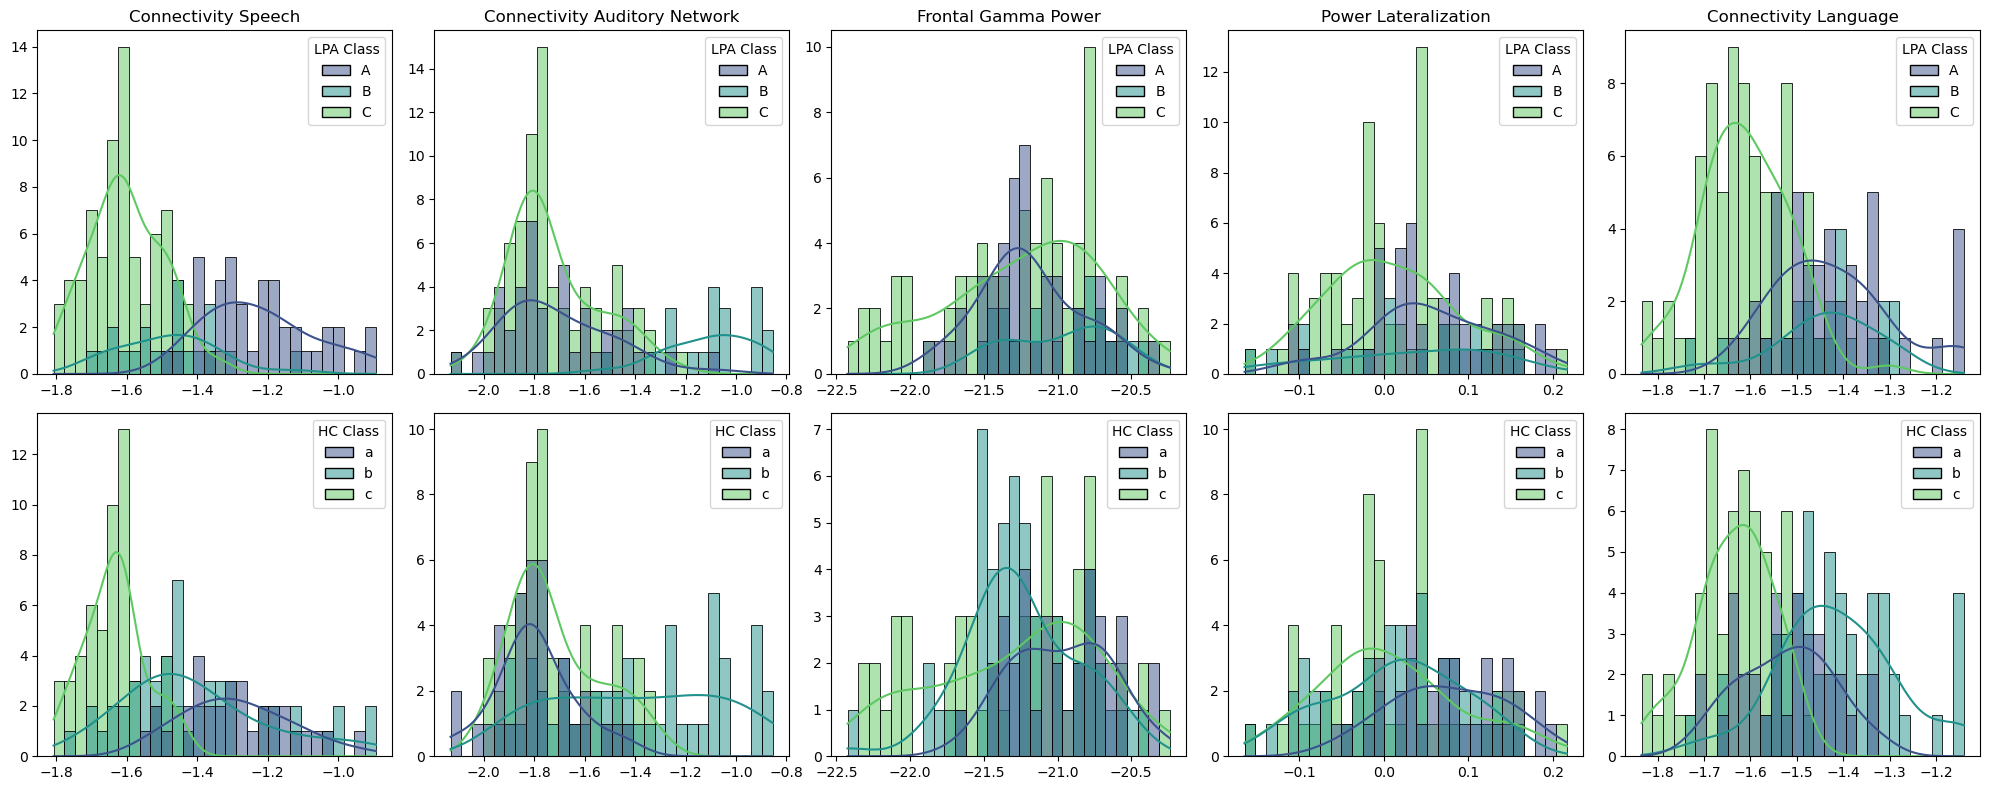

In [29]:
# Plot hitogram of each variable in eeg vars

# Create 4 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

sns.histplot(data=plotting_df, x="Connectivity Speech", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 0])
sns.histplot(data=plotting_df, x="Connectivity Speech", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 0])
axs[0, 0].set_title("Connectivity Speech")
axs[1, 0].set_title("")
axs[0, 0].set_xlabel("")
axs[1, 0].set_xlabel("")
axs[0, 0].set_ylabel("")
axs[1, 0].set_ylabel("")
sns.histplot(data=plotting_df, x="Connectivity Auditory Network", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 1])
sns.histplot(data=plotting_df, x="Connectivity Auditory Network", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 1])
axs[0, 1].set_title("Connectivity Auditory Network")
axs[1, 1].set_title("")
axs[0, 1].set_xlabel("")
axs[1, 1].set_xlabel("")
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")
sns.histplot(data=plotting_df, x="Frontal Gamma Power", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 2])
sns.histplot(data=plotting_df, x="Frontal Gamma Power", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 2])
axs[0, 2].set_title("Frontal Gamma Power")
axs[1, 2].set_title("")
axs[0, 2].set_xlabel("")
axs[1, 2].set_xlabel("")
axs[0, 2].set_ylabel("")
axs[1, 2].set_ylabel("")
sns.histplot(data=plotting_df, x="Power Lateralization", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 3])
sns.histplot(data=plotting_df, x="Power Lateralization", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 3])
axs[0, 3].set_title("Power Lateralization")
axs[1, 3].set_title("")
axs[0, 3].set_xlabel("")
axs[1, 3].set_xlabel("")
axs[0, 3].set_ylabel("")
axs[1, 3].set_ylabel("")
sns.histplot(data=plotting_df, x="Connectivity Language", hue="LPA Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[0, 4])
sns.histplot(data=plotting_df, x="Connectivity Language", hue="HC Class", kde=True, palette=palette, bins=30, alpha=0.5, ax=axs[1, 4])
axs[0, 4].set_title("Connectivity Language")
axs[1, 4].set_title("")
axs[0, 4].set_xlabel("")
axs[1, 4].set_xlabel("")
axs[0, 4].set_ylabel("")
axs[1, 4].set_ylabel("")
plt.tight_layout()

# Save the plot
if not os.path.exists(f"../../Figures/"):
    os.makedirs(f"../../Figures//")

plt.savefig(f"../../Figures/Main/eeg_features_histograms_{date}.png", dpi=300, bbox_inches='tight')



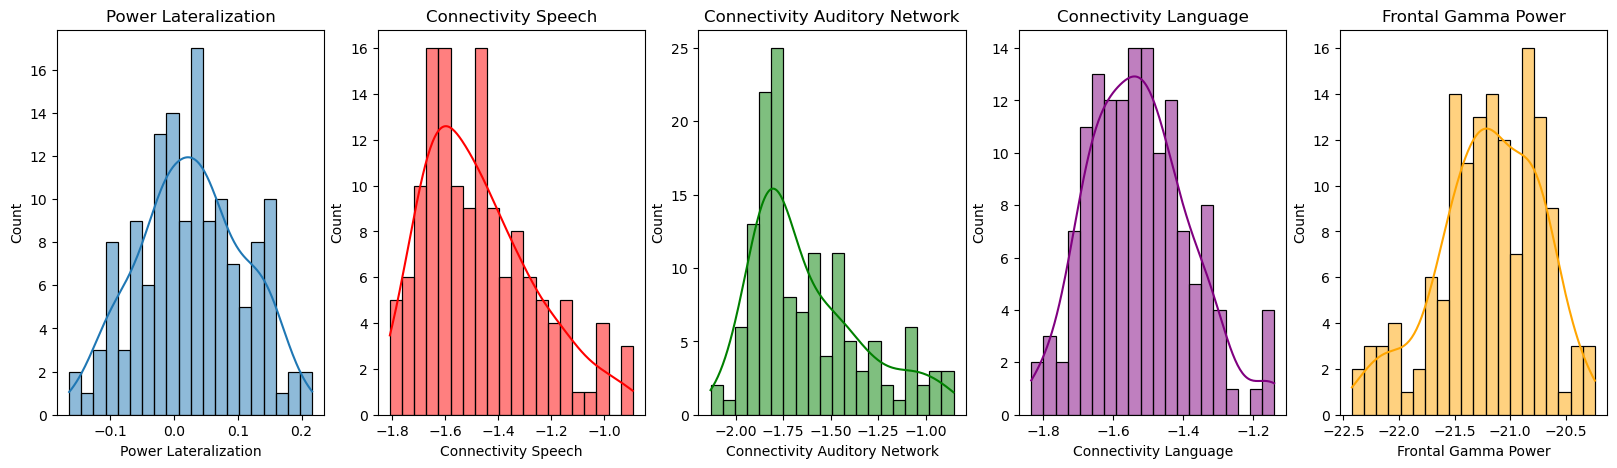

In [30]:
# Plot both features and check if they are normally distributed

# Do subplots 

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
if shapiro(plotting_df["Power Lateralization"])[1] < 0.05:
    print("Power Lateralization is not normally distributed", shapiro(plotting_df["Power Lateralization"])[1])

if shapiro(plotting_df["Connectivity Speech"])[1] < 0.05:
    print("Connectivity Speech is not normally distributed", shapiro(plotting_df["Connectivity Speech"])[1])

if shapiro(plotting_df["Connectivity Auditory Network"])[1] < 0.05:
    print("Connectivity Auditory Network is not normally distributed", shapiro(plotting_df["Connectivity Auditory Network"])[1])

if shapiro(plotting_df["Connectivity Language"])[1] < 0.05:
    print("Connectivity Language is not normally distributed", shapiro(plotting_df["Connectivity Language"])[1])

if shapiro(plotting_df["Frontal Gamma Power"])[1] < 0.05:
    print("Frontal Gamma Power is not normally distributed", shapiro(plotting_df["Frontal Gamma Power"])[1])

sns.histplot(plotting_df["Power Lateralization"], kde=True, ax=axs[0], bins=20)
sns.histplot(plotting_df["Connectivity Speech"], kde=True, ax=axs[1], bins=20, color="red")
sns.histplot(plotting_df["Connectivity Auditory Network"], kde=True, ax=axs[2], bins=20, color="green")
sns.histplot(plotting_df["Connectivity Language"], kde=True, ax=axs[3], bins=20, color="purple")
sns.histplot(plotting_df["Frontal Gamma Power"], kde=True, ax=axs[4], bins=20, color="orange")

# Add title and labels

axs[0].set_title("Power Lateralization")
axs[1].set_title("Connectivity Speech")
axs[2].set_title("Connectivity Auditory Network")
axs[3].set_title("Connectivity Language")
axs[4].set_title("Frontal Gamma Power")

# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/eeg_features_individual_histograms_{date}.png", dpi=300, bbox_inches='tight')


### Plot the distribution of the classes


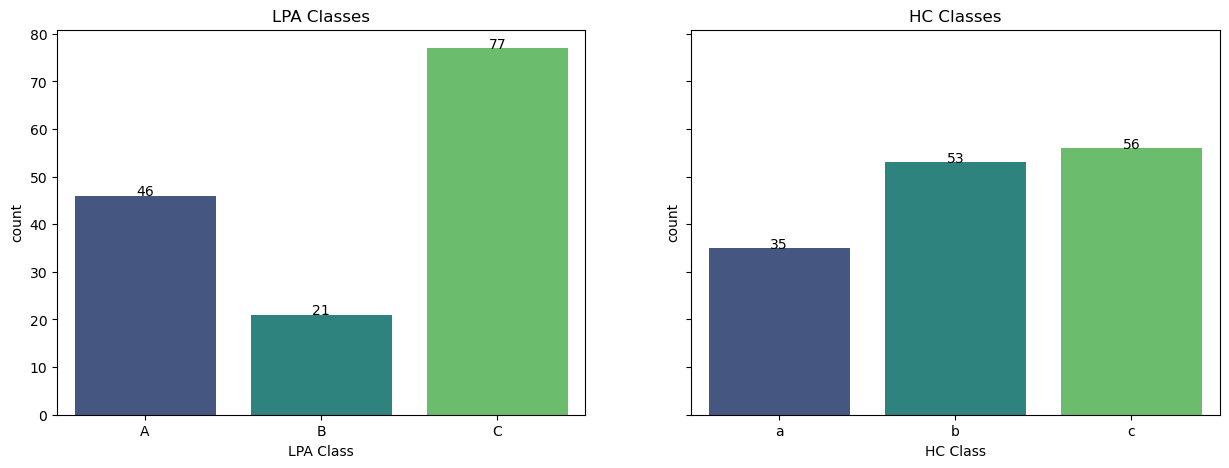

In [31]:
# Make sure they share the same y-axis
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.countplot(data=plotting_df, x="LPA Class", ax=ax[0], palette=palette)
ax[0].set_title("LPA Classes")

# Add counts to the bars in the plot
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

sns.countplot(data=plotting_df, x="HC Class", ax=ax[1], palette=palette)
ax[1].set_title("HC Classes")

# Add counts to the bars in the plot
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')


# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/LPA_HC_classes_size_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


## **3D Plotting** classes using UMAP, PCA or t-SNE

In [32]:
# Load the data
dim_reduction_df = pd.read_csv(f"../../Datasets/hierarchical/source/{date}/combined/MICE/5Dcombined_data_{date}.csv")

# Keep only the eeg variables
dim_reduction_df = dim_reduction_df[eeg_vars]

# Normalize the data
dim_reduction_df = (dim_reduction_df - dim_reduction_df.mean()) / dim_reduction_df.std()
dim_reduction_df


,auditory_con_6,lang_comp_con_6,speech_con_6_left,front_gamma_6,gamma_lat_6
0,0.091716,2.573154,1.139389,-0.493375,0.022771
1,-0.708993,0.071701,-0.933383,0.262605,0.167193
2,-0.690122,-0.656346,-0.002112,-2.062992,-0.541724
3,0.677772,-0.537582,-1.397818,-0.950743,-2.383233
4,-0.487253,-0.432078,0.150907,-0.858837,-1.682449
...,...,...,...,...,...
139,-0.568656,-0.544815,-0.280481,0.596665,0.195884
140,1.918149,1.694759,-0.298238,-0.587502,-1.552500
141,-0.477100,-1.239995,-1.318751,0.189308,-0.063540
142,0.467966,1.187249,2.211642,0.006792,-1.441595


In [33]:
# Set seed for reproducibility
np.random.seed(333)

### Feature reduction using UMAP

In [34]:
embedded_umap_2 = umap.UMAP(n_components=2, random_state=0).fit_transform(dim_reduction_df.values)
embedded_umap_3 = umap.UMAP(n_components=3, random_state=0).fit_transform(dim_reduction_df.values)

c:\Users\gabot\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


c:\Users\gabot\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [35]:
# Save the UMAP data
umap_df_2d = pd.DataFrame(embedded_umap_2, columns=["umap1", "umap2"], index=dim_reduction_df.index)
umap_df_3d = pd.DataFrame(embedded_umap_3, columns=["umap1", "umap2","umap3"], index=dim_reduction_df.index)

#### **2D UMAP**

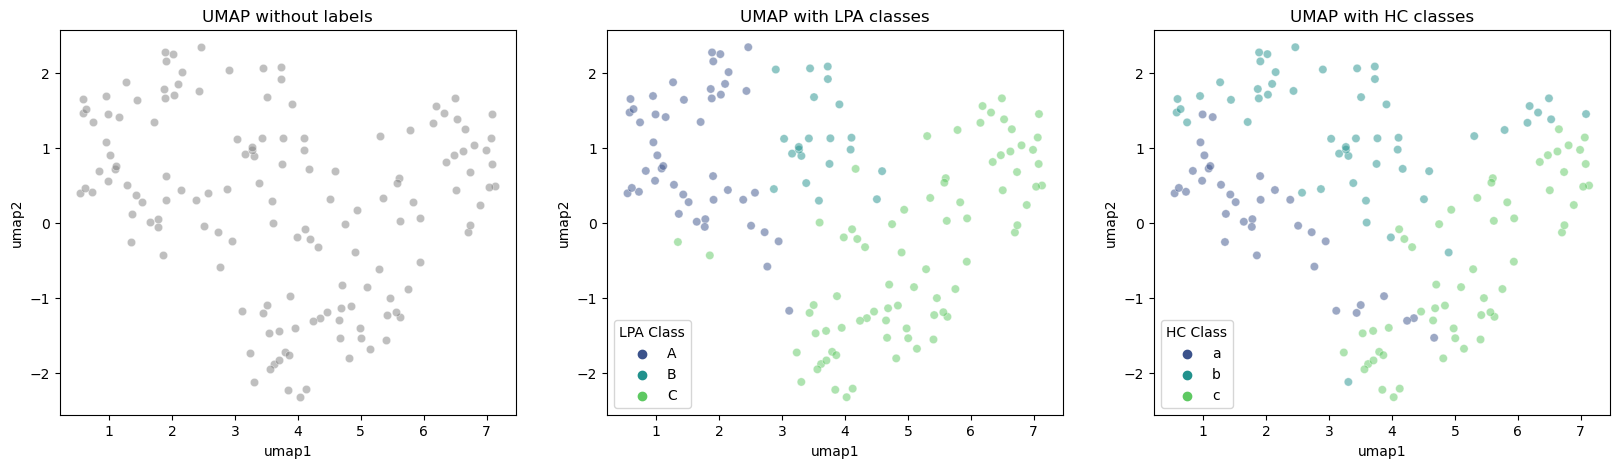

In [36]:
# Create 3 subplots, one for the umpa no labels, one for the LPA classes and one for the HC classes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Plot UMAP without labels
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", ax=axs[0], color="gray", alpha=0.5)
axs[0].set_title("UMAP without labels")
# Plot UMAP with LPA classes
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", hue=plotting_df["LPA Class"], ax=axs[1], palette=palette, alpha=0.5)
axs[1].set_title("UMAP with LPA classes")
# Plot UMAP with HC classes
sns.scatterplot(data=umap_df_2d, x="umap1", y="umap2", hue=plotting_df["HC Class"], ax=axs[2], palette=palette, alpha=0.5)
axs[2].set_title("UMAP with HC classes")
# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/umap_2d_{date}.png", dpi=300, bbox_inches='tight')

#### **3D UMAP**

In [37]:
# Create subplots with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, 
                   specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                   subplot_titles=("UMAP without labels", "UMAP with LPA classes", "UMAP with HC classes"))

# 1. UMAP without labels
fig1 = px.scatter_3d(umap_df_3d, x='umap1', y='umap2', z='umap3', 
                    opacity=0.7, color_discrete_sequence=['gray'])
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# 2. UMAP with LPA classes
fig2 = px.scatter_3d(umap_df_3d, x='umap1', y='umap2', z='umap3', 
                    color=plotting_df["LPA Class"], opacity=0.7)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# 3. UMAP with HC classes
fig3 = px.scatter_3d(umap_df_3d, x='umap1', y='umap2', z='umap3', 
                    color=plotting_df["HC Class"], opacity=0.7)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)

# Update layout
fig.update_layout(
    height=700,
    width=1600,
    showlegend=True,
    scene=dict(
        aspectmode='data'  # Preserve aspect ratio
    ),
    scene2=dict(
        aspectmode='data'
    ),
    scene3=dict(
        aspectmode='data'
    )
)

# Make all subplots use the same camera angle for comparison
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1.5, z=0.5)
)

fig.update_scenes(
    camera=camera,
    row=1, col=1
)
fig.update_scenes(
    camera=camera,
    row=1, col=2
)
fig.update_scenes(
    camera=camera,
    row=1, col=3
)

fig.show()

# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")
#fig.write_image(f"../../Figures/Supplementary/{date}/umap_3d_{date}.png", width=1800, height=600, scale=2)


### Feature reduction using PCA

In [38]:
# Apply PCA to the data
pca = PCA(n_components=5)
p_components = pca.fit_transform(dim_reduction_df.values)
pca_df = pd.DataFrame(data = p_components)

pca_df

,0,1,2,3,4
0,2.362948,1.157592,-0.601880,-0.125904,-0.932750
1,-0.672342,-0.398435,-0.213567,-0.092438,-0.900546
2,-1.045854,1.384367,-1.288993,0.634870,0.617752
3,-1.818574,2.125207,1.124926,-0.441508,0.043333
4,-0.878137,1.426024,-0.442623,-0.820725,0.583902
...,...,...,...,...,...
139,-0.557246,-0.808633,-0.149414,-0.320160,-0.063285
140,0.947979,2.301764,1.685957,-0.058514,-0.594314
141,-1.775949,-0.576516,0.170447,0.071334,-0.153893
142,1.947458,1.398575,-0.069216,-1.413253,0.920587


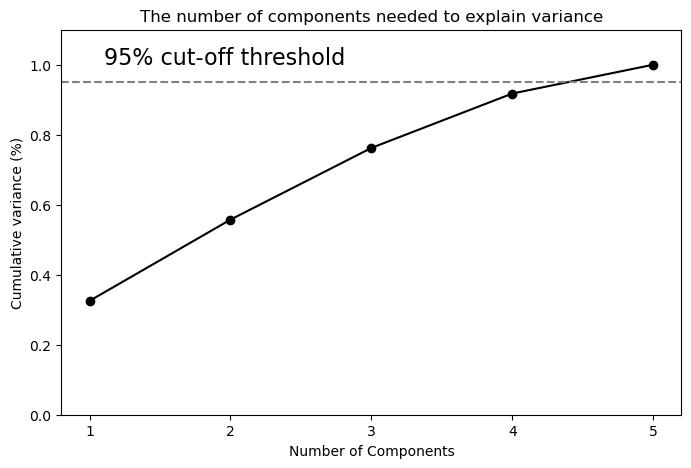

In [39]:
# Plot the variance 
plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y) + 1, step=1)  # Adjust xi to match the length of y

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 6, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)


# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")

plt.savefig(f"../../Figures/Supplementary/{date}/pca_variance_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


#### **2D PCA Mapping**

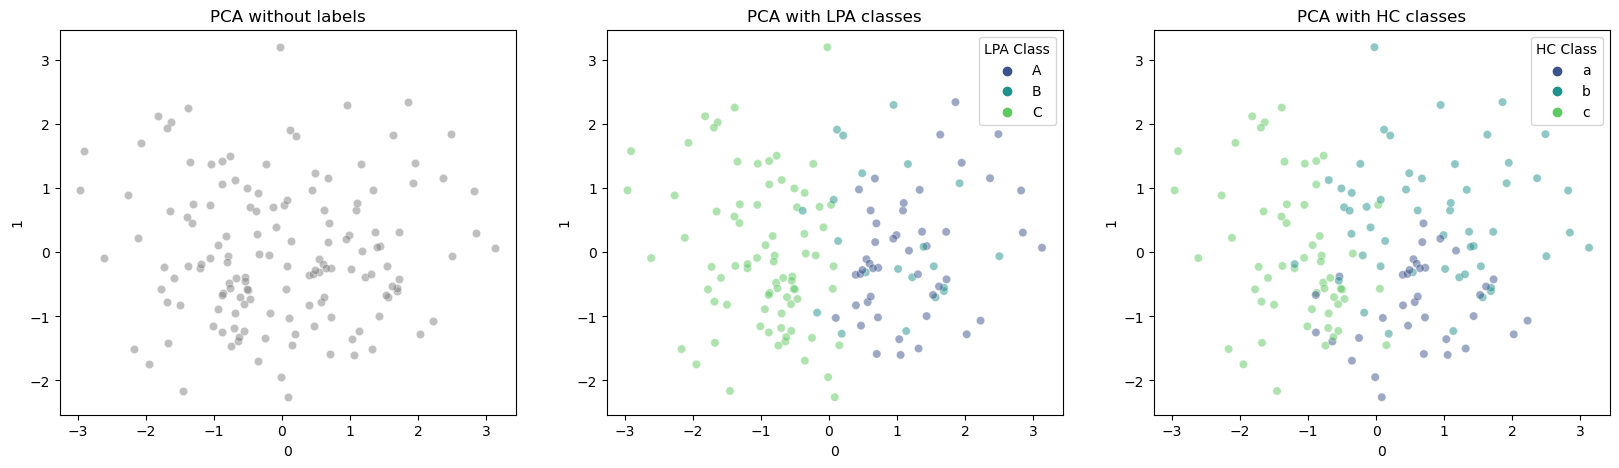

In [40]:
# Create 3 subplots, one for the pca no labels, one for the LPA classes and one for the HC classes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Plot PCA without labels
sns.scatterplot(data=pca_df, x=0, y=1, ax=axs[0], color="gray", alpha=0.5)
axs[0].set_title("PCA without labels")
# Plot PCA with LPA classes
sns.scatterplot(data=pca_df, x=0, y=1, hue=plotting_df["LPA Class"], ax=axs[1], palette=palette, alpha=0.5)
axs[1].set_title("PCA with LPA classes")
# Plot PCA with HC classes
sns.scatterplot(data=pca_df, x=0, y=1, hue=plotting_df["HC Class"], ax=axs[2
], palette=palette, alpha=0.5)
axs[2].set_title("PCA with HC classes")
# Save the plot
plt.savefig(f"../../Figures/Supplementary/{date}/pca_2d_{date}.png", dpi=300, bbox_inches='tight')



#### **3D PCA**

In [41]:
# Create subplots with 1 row and 3 columns for 3D PCA

fig = make_subplots(rows=1, cols=3,
                   specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                   subplot_titles=("PCA without labels", "PCA with LPA classes", "PCA with HC classes"))
# 1. PCA without labels
fig1 = px.scatter_3d(pca_df, x=0, y=1, z=2, 
                    opacity=0.7, color_discrete_sequence=['gray'])
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)
# 2. PCA with LPA classes
fig2 = px.scatter_3d(pca_df, x=0, y=1, z=2, 
                    color=plotting_df["LPA Class"], opacity=0.7)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)
# 3. PCA with HC classes
fig3 = px.scatter_3d(pca_df, x=0, y=1, z=2, 
                    color=plotting_df["HC Class"], opacity=
0.7)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)
# Update layout
fig.update_layout(
    height=700,
    width=1600,
    showlegend=True,
    scene=dict(
        aspectmode='data'  # Preserve aspect ratio
    ),
    scene2=dict(
        aspectmode='data'
    ),
    scene3=dict(
        aspectmode='data'
    )
)
# Make all subplots use the same camera angle for comparison
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1.5, z=0.5)
)
fig.update_scenes(
    camera=camera,
    row=1, col=1
)
fig.update_scenes(
    camera=camera,
    row=1, col=2
)
fig.update_scenes(
    camera=camera,
    row=1, col=3
)
fig.show()


### Feature reduction using t-SNE

In [42]:
# t-SNE 2D
tsne_2d = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_components_2d = tsne_2d.fit_transform(dim_reduction_df.values)
tsne_df_2d = pd.DataFrame(data = tsne_components_2d, columns = ['t-SNE1', 't-SNE2'])


# t-SNE 3D
tsne_3d = TSNE(n_components=3, random_state=0, perplexity=30, n_iter=1000)
tsne_components_3d = tsne_3d.fit_transform(dim_reduction_df.values)
tsne_df_3d = pd.DataFrame(data = tsne_components_3d, columns = ['t-SNE1', 't-SNE2', 't-SNE3'])

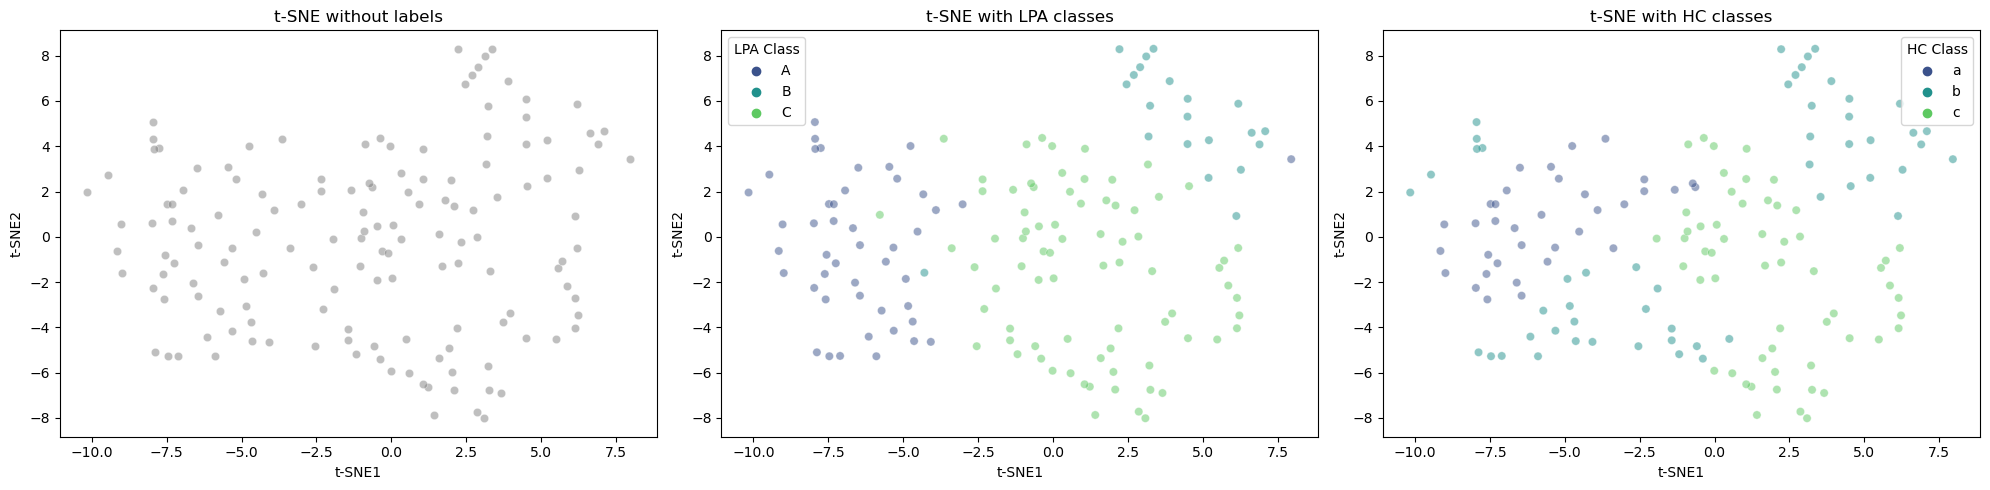

In [43]:
# Create 3 subplots, one for the t-SNE without labels, one for the LPA classes, and one for the HC classes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot t-SNE without labels
sns.scatterplot(data=tsne_df_2d, x="t-SNE1", y="t-SNE2", ax=axs[0], color="gray", alpha=0.5)
axs[0].set_title("t-SNE without labels")

# Plot t-SNE with LPA classes
sns.scatterplot(data=tsne_df_2d, x="t-SNE1", y="t-SNE2", hue=plotting_df["LPA Class"], ax=axs[1], palette=palette, alpha=0.5)
axs[1].set_title("t-SNE with LPA classes")

# Plot t-SNE with HC classes
sns.scatterplot(data=tsne_df_2d, x="t-SNE1", y="t-SNE2", hue=plotting_df["HC Class"], ax=axs[2], palette=palette, alpha=0.5)
axs[2].set_title("t-SNE with HC classes")

# Adjust the layout
plt.tight_layout()

# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")
plt.savefig(f"../../Figures/Supplementary/{date}/tsne_2d_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


In [44]:
# Create subplots with 1 row and 3 columns for 3D t-SNE
fig = make_subplots(rows=1, cols=3,
                   specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                   subplot_titles=("t-SNE without labels", "t-SNE with LPA classes", "t-SNE with HC classes"))

# 1. t-SNE without labels
fig1 = px.scatter_3d(tsne_df_3d, x='t-SNE1', y='t-SNE2', z='t-SNE3', 
                    opacity=0.7, color_discrete_sequence=['gray'])
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# 2. t-SNE with LPA classes
fig2 = px.scatter_3d(tsne_df_3d, x='t-SNE1', y='t-SNE2', z='t-SNE3', 
                    color=plotting_df["LPA Class"], opacity=0.7)
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# 3. t-SNE with HC classes
fig3 = px.scatter_3d(tsne_df_3d, x='t-SNE1', y='t-SNE2', z='t-SNE3', 
                    color=plotting_df["HC Class"], opacity=0.7)
for trace in fig3.data:
    fig.add_trace(trace, row=1, col=3)

# Update layout
fig.update_layout(
    height=700,
    width=1600,
    showlegend=True,
    scene=dict(
        aspectmode='data'  # Preserve aspect ratio
    ),
    scene2=dict(
        aspectmode='data'
    ),
    scene3=dict(
        aspectmode='data'
    )
)

# Make all subplots use the same camera angle for comparison
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.5, y=1.5, z=0.5)
)

fig.update_scenes(
    camera=camera,
    row=1, col=1
)
fig.update_scenes(
    camera=camera,
    row=1, col=2
)
fig.update_scenes(
    camera=camera,
    row=1, col=3
)

fig.show()



In [45]:
# Add umap data to the plotting_df
plotting_df["umap1"] = umap_df_2d["umap1"]
plotting_df["umap2"] = umap_df_2d["umap2"]

In [46]:
plotting_df.columns

Index(['subject', 'HC Class', 'ASD Likelihood', 'ASD Diagnosis', 'Sex', 'Site',
       'Frontal Gamma Power', 'Connectivity Auditory Network',
       'Connectivity Language', 'Connectivity Speech', 'Power Lateralization',
       'LPA Class', 'prob_class_1', 'prob_class_2', 'prob_class_3',
       'Receptive MSEL 6 months', 'Expressive MSEL 6 months',
       'Receptive MSEL 12 months', 'Expressive MSEL 12 months',
       'Receptive MSEL 18 months', 'Expressive MSEL 18 months',
       'Receptive MSEL 24 months', 'Expressive MSEL 24 months',
       'Receptive MSEL 36 months', 'Expressive MSEL 36 months', 'NVIQ',
       'umap1', 'umap2'],
      dtype='object')

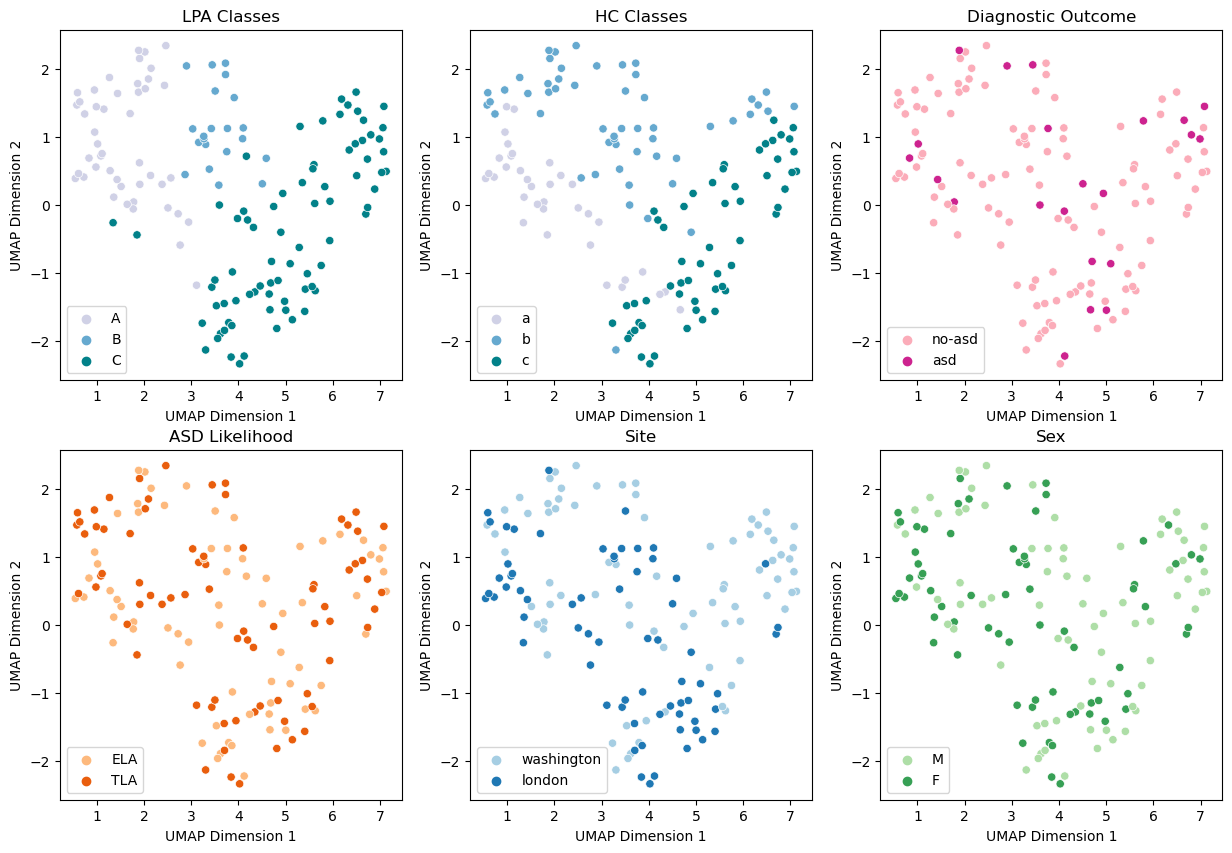

In [47]:
# Plot 2D scatterplot of the classes using UMAP

fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # Adjusted figsize for better visualization
ax = ax.flatten()  # Flatten the 2D array of axes into a 1D array

# Plot the distribution of the LPA classes
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="LPA Class", ax=ax[0], palette="PuBuGn")
ax[0].get_legend().remove()
ax[0].legend(loc='lower left')
ax[0].set_title("LPA Classes")
ax[0].set_ylabel("UMAP Dimension 2")
ax[0].set_xlabel("UMAP Dimension 1")

# Plot the distribution of the HC classes
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="HC Class", ax=ax[1], palette="PuBuGn", legend="full")
ax[1].get_legend().remove()
ax[1].legend(loc='lower left')
ax[1].set_title("HC Classes")
ax[1].set_ylabel("UMAP Dimension 2")
ax[1].set_xlabel("UMAP Dimension 1")

# Plot the distribution of outcomes
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="ASD Diagnosis", ax=ax[2], palette="RdPu")
ax[2].legend(loc='lower left')
ax[2].set_title("Diagnostic Outcome")
ax[2].set_ylabel("UMAP Dimension 2")
ax[2].set_xlabel("UMAP Dimension 1")

# Plot the distribution of group types
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="ASD Likelihood", ax=ax[3], palette="Oranges")
ax[3].legend(loc='lower left')
ax[3].set_title("ASD Likelihood")
ax[3].set_ylabel("UMAP Dimension 2")
ax[3].set_xlabel("UMAP Dimension 1")

# Plot the distribution of sites
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="Site", ax=ax[4], palette="Paired")
ax[4].legend(loc='lower left')
ax[4].set_title("Site")
ax[4].set_ylabel("UMAP Dimension 2")
ax[4].set_xlabel("UMAP Dimension 1")

# Plot the distribution of sex
sns.scatterplot(data=plotting_df, x="umap1", y="umap2", hue="Sex", ax=ax[5], palette="Greens")
ax[5].legend(loc='lower left')
ax[5].set_title("Sex")
ax[5].set_ylabel("UMAP Dimension 2")
ax[5].set_xlabel("UMAP Dimension 1")


# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")
plt.savefig(f"../../Figures/Supplementary/{date}/demographics_UMAP_{date}.png", dpi=300, bbox_inches='tight')

plt.show()


### Demographics table

In [48]:
# Create tables for HC Class and LPA Class
hc_table = create_descriptive_table(plotting_df, 'HC Class', clean_eeg_vars)
lpa_table = create_descriptive_table(plotting_df, 'LPA Class', clean_eeg_vars)

# Combine the tables
combined_table = pd.concat([hc_table, lpa_table], ignore_index=True)
# Save the combined table
combined_table.to_csv(f"../../Tables/Main/{date}/mean_eeg_features_descriptive_stats_{date}.csv", index=False)
combined_table

,Classification,Group,n,Frontal Gamma Power M (SD),Frontal Gamma Power Range,Connectivity Auditory Network M (SD),Connectivity Auditory Network Range,Connectivity Language M (SD),Connectivity Language Range,Connectivity Speech M (SD),Connectivity Speech Range,Power Lateralization M (SD),Power Lateralization Range
0,HC Class,Group b,53,-21.24 (0.39),-22.42 to -20.45,-1.40 (0.33),-1.92 to -0.85,-1.41 (0.13),-1.73 to -1.14,-1.41 (0.21),-1.77 to -0.89,0.01 (0.08),-0.15 to 0.15
1,HC Class,Group c,56,-21.28 (0.55),-22.32 to -20.24,-1.72 (0.18),-2.00 to -1.32,-1.63 (0.08),-1.83 to -1.47,-1.63 (0.09),-1.81 to -1.43,0.01 (0.08),-0.16 to 0.22
2,HC Class,Group a,35,-20.98 (0.33),-21.66 to -20.33,-1.80 (0.16),-2.13 to -1.42,-1.52 (0.10),-1.71 to -1.33,-1.29 (0.15),-1.54 to -0.93,0.08 (0.07),-0.06 to 0.20
3,LPA Class,Group A,46,-21.19 (0.35),-21.89 to -20.34,-1.71 (0.22),-2.13 to -1.07,-1.42 (0.13),-1.64 to -1.14,-1.22 (0.15),-1.48 to -0.89,0.06 (0.08),-0.11 to 0.20
4,LPA Class,Group C,77,-21.25 (0.53),-22.42 to -20.24,-1.72 (0.18),-2.12 to -1.22,-1.61 (0.10),-1.83 to -1.30,-1.60 (0.10),-1.81 to -1.33,0.01 (0.08),-0.16 to 0.22
5,LPA Class,Group B,21,-20.98 (0.35),-21.54 to -20.45,-1.10 (0.17),-1.53 to -0.85,-1.44 (0.11),-1.73 to -1.29,-1.48 (0.14),-1.70 to -1.13,0.03 (0.09),-0.15 to 0.15


### **Lateralization** Check if laterlization is significant from 0

In [49]:
# Do this for LPA 

for group in plotting_df["LPA Class"].unique():
    group_data = plotting_df[plotting_df["LPA Class"] == group]["Power Lateralization"]
    # Drop NaN values
    group_data = group_data.dropna()
    # Perform one-sample t-test
    t_stat, p_value = stats.ttest_1samp(group_data, 0)

    if p_value < 0.05:
        print(f"***Group {group} is significantly different from 0 (p < 0.05), t-statistic: {t_stat}, p-value: {p_value.round(4)}")

    else:
        print(f"Group {group} is not significantly different from 0 (p >= 0.05)")




***Group A is significantly different from 0 (p < 0.05), t-statistic: 4.834751733354755, p-value: 0.0
Group C is not significantly different from 0 (p >= 0.05)
Group B is not significantly different from 0 (p >= 0.05)


In [50]:
# Do this for HC Class
for group in plotting_df["HC Class"].unique():
    group_data = plotting_df[plotting_df["HC Class"] == group]["Power Lateralization"]
    # Drop NaN values
    group_data = group_data.dropna()
    # Perform one-sample t-test
    t_stat, p_value = stats.ttest_1samp(group_data, 0)

    if p_value < 0.05:
        print(f"***Group {group} is significantly different from 0 (p < 0.05), t-statistic: {t_stat}, p-value: {p_value.round(4)}")

    else:
        print(f"Group {group} is not significantly different from 0 (p >= 0.05)")

Group b is not significantly different from 0 (p >= 0.05)
Group c is not significantly different from 0 (p >= 0.05)
***Group a is significantly different from 0 (p < 0.05), t-statistic: 6.619786629429643, p-value: 0.0


### **Demographics Chi-tests**


Table for LPA Class:
          Variable Statistics Chi-square p-value Cramer's V    Class A    Class B    Class C
 **ASD Diagnosis**                                                 NaN        NaN        NaN
               asd      n (%)       1.15   0.561      0.092  5 (11.4%)  4 (20.0%) 13 (18.1%)
            no-asd      n (%)        NaN     NaN        NaN 39 (88.6%) 16 (80.0%) 59 (81.9%)
**ASD Likelihood**                                                 NaN        NaN        NaN
               ELA      n (%)       0.21   0.900      0.038 22 (47.8%) 11 (52.4%) 36 (46.8%)
               TLA      n (%)        NaN     NaN        NaN 24 (52.2%) 10 (47.6%) 41 (53.2%)
           **Sex**                                                 NaN        NaN        NaN
                 F      n (%)       2.15   0.341      0.122 25 (54.3%) 11 (52.4%) 32 (41.6%)
                 M      n (%)        NaN     NaN        NaN 21 (45.7%) 10 (47.6%) 45 (58.4%)
          **Site**                              

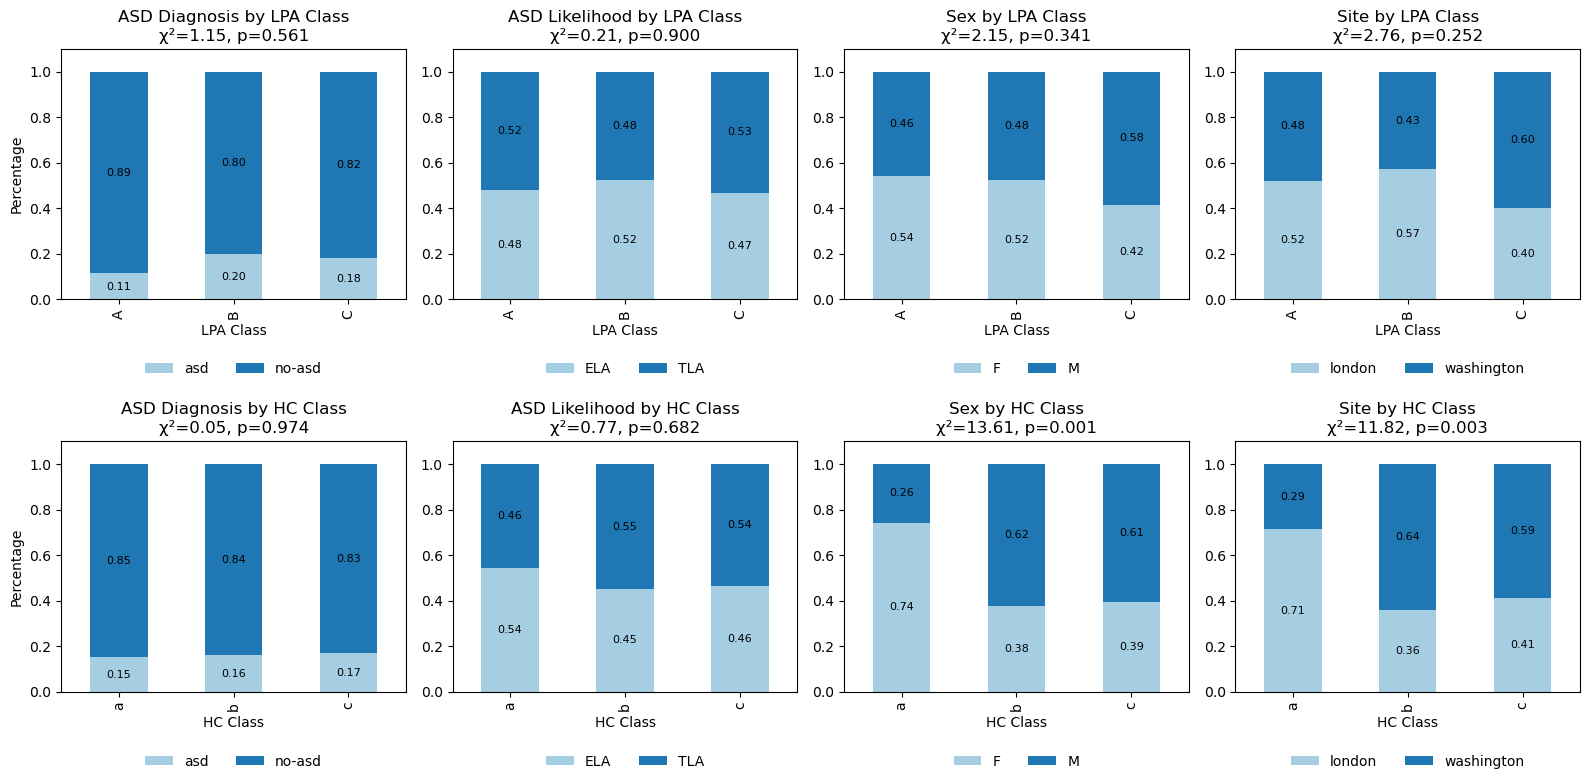

In [53]:
# Define orders for consistent presentation
hc_order = ["a", "b", "c"]
lpa_order = ["A", "B", "C"]

# Perform the analysis
stratification_methods = ['LPA Class','HC Class']
demographic_vars = ['ASD Diagnosis', 'ASD Likelihood', 'Sex', 'Site']

# Create the demographic table
demo_tables = create_demographic_table(plotting_df, stratification_methods, demographic_vars)

# Create the demographic plots
fig = create_demographic_plots(plotting_df, stratification_methods, demographic_vars,
                                f"../../Figures/Supplementary/{date}/hc_lpa_demographics_comparison_{date}.png")

# Create publication tables
pub_tables = format_table_for_publication(demo_tables)

# Display tables
for method, table in pub_tables.items():
    print(f"\nTable for {method}:")
    print(table.to_string(index=False))

# Save tables to CSV
for method, table in pub_tables.items():
    table.to_csv(f"../../Tables/Main/{date}/eeg_features_{method.replace(' ', '_')}_demographics.csv", index=False)


### **Sankey Plot**

In [54]:
# Create a contingency table
contingency_table = pd.crosstab(plotting_df["LPA Class"], plotting_df["HC Class"])
# Perform the Chi-squared test
print(contingency_table)

HC Class    a   b   c
LPA Class            
A          27  19   0
B           0  21   0
C           8  13  56


In [55]:
# Calculate overlap
overlap = contingency_table.values.diagonal().sum()
total_samples = contingency_table.values.sum()
degree_of_overlap = overlap / total_samples
print("Degree of Overlap:", degree_of_overlap)


Degree of Overlap: 0.7222222222222222


In [ ]:
# Prepare data for the Sankey diagram
source = []
target = []
values = []

# Get the number of clusters in hc_class and lpa_class
hc_labels = list(contingency_table.index)
lpa_labels = list(contingency_table.columns)

for hc_index, hc_cluster in enumerate(hc_labels):
    for lpa_index, lpa_cluster in enumerate(lpa_labels):
        count = contingency_table.loc[hc_cluster, lpa_cluster]
        if count > 0:
            source.append(hc_index)  # Use index for HC clusters
            target.append(lpa_index + len(hc_labels))  # Offset LPA clusters by the number of HC clusters
            values.append(count)

# Make each side have the same color

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=40,
        line=dict(color="black", width=0.5), # Set the line color and width
        label=[f'LPA {i}' for i in hc_labels] + 
               [f'HC {j}' for j in lpa_labels]
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

fig.update_layout(title_text="Sankey Diagram of Overlap", font_size=20, width=1000, height=500, autosize=True)

# Save the plot
if not os.path.exists(f"../../Figures/Supplementary/{date}/"):
    os.makedirs(f"../../Figures/Supplementary/{date}/")

#fig.write_image(f"../../Figures/Main/{date}/sankey_diagram_{date}.png" , width=1000, height=500, scale=2)

fig.show()



: 

: 

In [106]:
chi_results_df

,Variable,p_value,chi2_stat,analyis,p_value_adj
0,sex,0.001106,13.614827,hc_class,0.008844
1,outcome,0.974324,0.052023,hc_class,0.974324
2,group_type,0.681852,0.765885,hc_class,0.909136
3,site,0.002709,11.822137,hc_class,0.010837
4,sex,0.340880,2.152449,lpa_class,0.681760
5,outcome,0.561370,1.154750,lpa_class,0.898192
6,group_type,0.900498,0.209615,lpa_class,0.974324
7,site,0.252025,2.756455,lpa_class,0.672066


## **Language profiles**

### Expressive

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\881863961.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_hc = normalized_df.groupby("HC Class").mean()
C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\881863961.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_mp = normalized_df.groupby("LPA Class").mean()


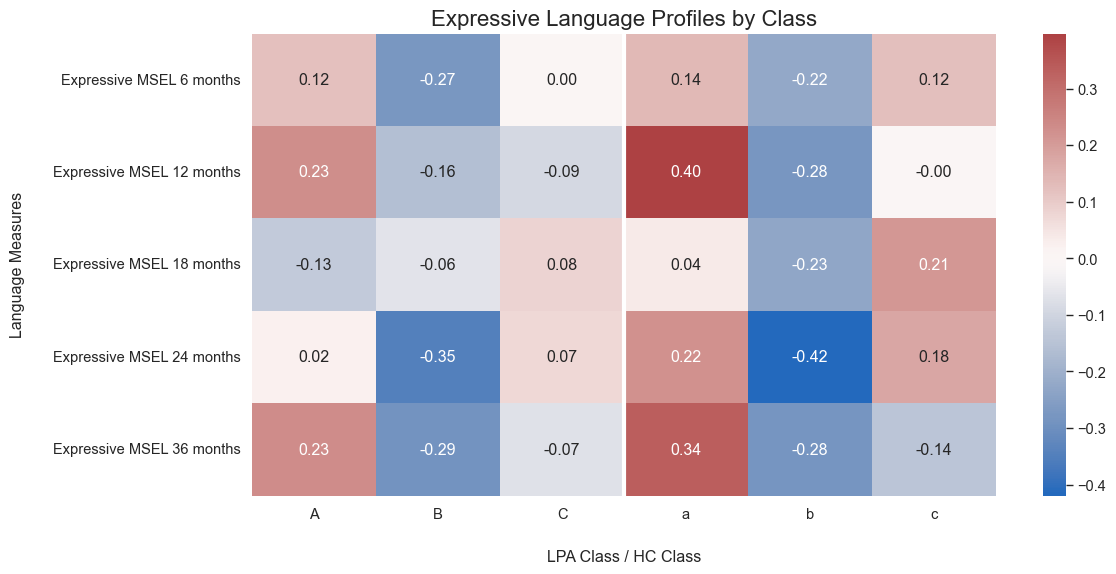

In [131]:
cleaned_expres_vars = [var for var in cleaned_language_vars if "expressive" in var.lower() ]

measures= cleaned_expres_vars
var_interest = "Expressive"
normalized_df = plotting_df.copy()
for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Group by 'cluster' (hc_class) and 'lpa_class' and calculate the mean
profiles_hc = normalized_df.groupby("HC Class").mean()
profiles_mp = normalized_df.groupby("LPA Class").mean()

profiles_hc["class"] = profiles_hc.index
profiles_mp["class"] = profiles_mp.index

# Combine both profiles
profiles_normed = pd.concat([profiles_mp, profiles_hc], axis=0)


# Select relevant language profiles
lang_profiles = profiles_normed[measures]

# Plot the profiles
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(lang_profiles.T, cmap="vlag", center=0, ax=ax, annot=True, fmt=".2f")
plt.title(f"{var_interest} Language Profiles by Class", fontsize=16)
# Add a horizontal line to separate the two classes
plt.axvline(x=3, color="white", lw=3)
#plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=["HC High Avg", "HC Low Avg 1", "LPA High Avg", "LPA Low Avg"], rotation=25)

plt.xlabel("LPA Class / HC Class",labelpad=20)

plt.ylabel("Language Measures",labelpad=20)

# Save the plot

plt.savefig(f"../../Figures/Supplementary/{date}/{var_interest}_language_profiles_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


## Receptive

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\1701921448.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_hc = normalized_df.groupby("HC Class").mean()
C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\1701921448.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_mp = normalized_df.groupby("LPA Class").mean()


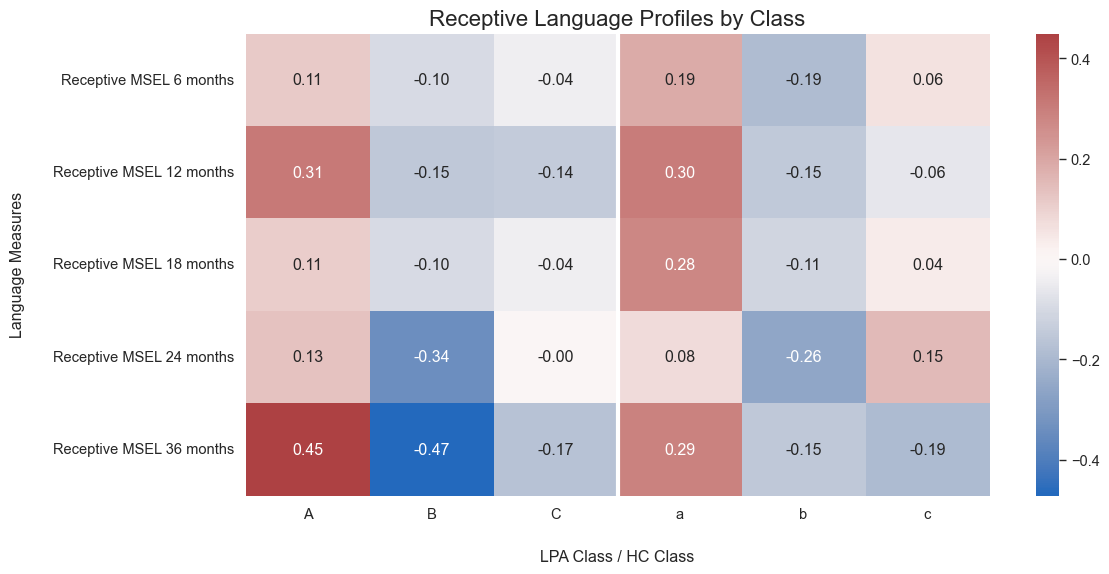

In [132]:
### Expressive
cleaned_receptive_vars = [var for var in cleaned_language_vars if "receptive" in var.lower() ]

measures= cleaned_receptive_vars
var_interest = "Receptive"
normalized_df = plotting_df.copy()
for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Group by 'cluster' (hc_class) and 'lpa_class' and calculate the mean
profiles_hc = normalized_df.groupby("HC Class").mean()
profiles_mp = normalized_df.groupby("LPA Class").mean()

profiles_hc["class"] = profiles_hc.index
profiles_mp["class"] = profiles_mp.index

# Combine both profiles
profiles_normed = pd.concat([profiles_mp, profiles_hc], axis=0)


# Select relevant language profiles
lang_profiles = profiles_normed[measures]

# Plot the profiles
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(lang_profiles.T, cmap="vlag", center=0, ax=ax, annot=True, fmt=".2f")
plt.title(f"{var_interest} Language Profiles by Class", fontsize=16)
# Add a horizontal line to separate the two classes
plt.axvline(x=3, color="white", lw=3)
plt.xlabel("LPA Class / HC Class",labelpad=20)

plt.ylabel("Language Measures",labelpad=20)
 
# Save the plot

plt.savefig(f"../../Figures/Supplementary/{date}/{var_interest}_language_profiles_{date}.png", dpi=300, bbox_inches='tight')
plt.show()


### EEG Profiles

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\2390912523.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_hc = normalized_df.groupby("HC Class").mean()
C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\2390912523.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_mp = normalized_df.groupby("LPA Class").mean()


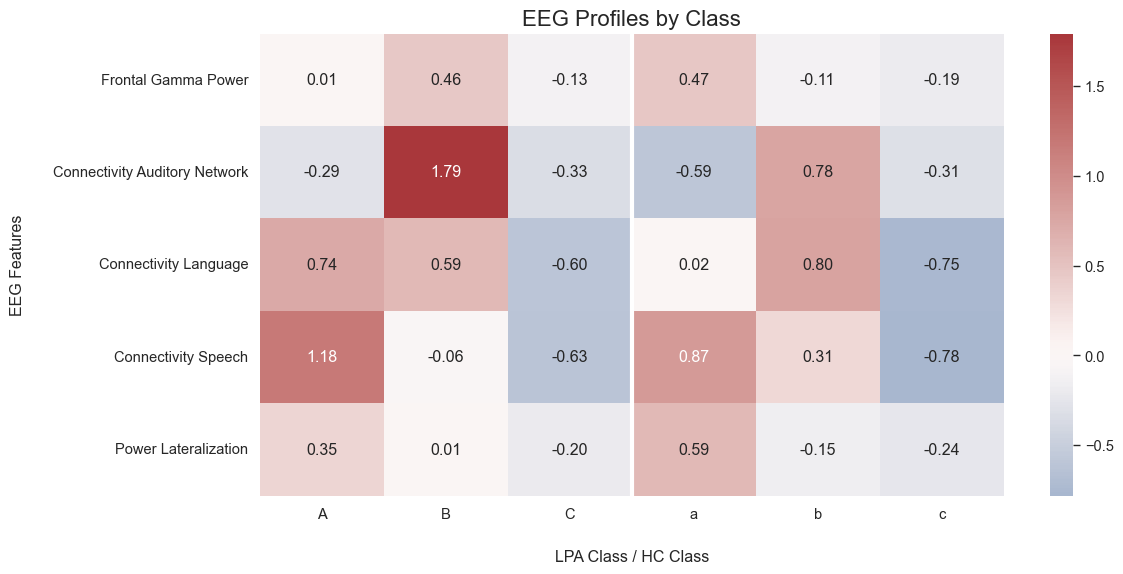

In [133]:

measures= clean_eeg_vars
var_interest = "EEG"
normalized_df = plotting_df.copy()
for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Group by 'cluster' (hc_class) and 'lpa_class' and calculate the mean
profiles_hc = normalized_df.groupby("HC Class").mean()
profiles_mp = normalized_df.groupby("LPA Class").mean()

profiles_hc["class"] = profiles_hc.index
profiles_mp["class"] = profiles_mp.index

# Combine both profiles
profiles_normed = pd.concat([profiles_mp, profiles_hc], axis=0)


# Select relevant language profiles
lang_profiles = profiles_normed[measures]

# Plot the profiles
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(lang_profiles.T, cmap= "vlag",  # Use a diverging color palette
           #cmap="RdBu_r",  # Use a diverging color palette
             center=0, ax=ax, annot=True, fmt=".2f")
plt.title(f"{var_interest} Profiles by Class", fontsize=16)
# Add a horizontal line to separate the two classes
plt.axvline(x=3, color="white", lw=3)
plt.xlabel("LPA Class / HC Class",labelpad=20)

plt.ylabel("EEG Features",labelpad=20)

# Save the plot

plt.savefig(f"../../Figures/Supplementary/{date}/{var_interest}_profiles_{date}.png", dpi=300, bbox_inches='tight')
plt.show()

## **Language growth curves**

In [32]:
## Create wide long format for langauge measures

lang_wide=plotting_df.copy()

expressive_df= lang_wide[["HC Class"] + ["LPA Class"] + ["subject"] + cleaned_expres_vars]
receptive_df= lang_wide[["HC Class"] + ["LPA Class"] + ["subject"]+ cleaned_receptive_vars]



# Rename the timepoints
expressive_df = expressive_df.melt(id_vars=["HC Class", "LPA Class","subject"], var_name="Age", value_name="score")
expressive_df["Age"] = expressive_df["Age"].str.extract("(\d+)").astype(int)
expressive_df["Measure"] = "Expressive"

# Rename the timepoints
receptive_df = receptive_df.melt(id_vars=["HC Class", "LPA Class","subject"], var_name="Age", value_name="score")
receptive_df["Age"] = receptive_df["Age"].str.extract("(\d+)").astype(int)
receptive_df["Measure"] = "Receptive"


In [35]:
expressive_df.head()

,HC Class,LPA Class,subject,Age,score,Measure
0,b,A,2,6,5.0,Expressive
1,c,C,3,6,7.0,Expressive
2,c,C,5,6,5.0,Expressive
3,c,C,6,6,4.0,Expressive
4,c,C,8,6,5.0,Expressive


In [58]:
ages = [6, 12, 18, 24, 36]

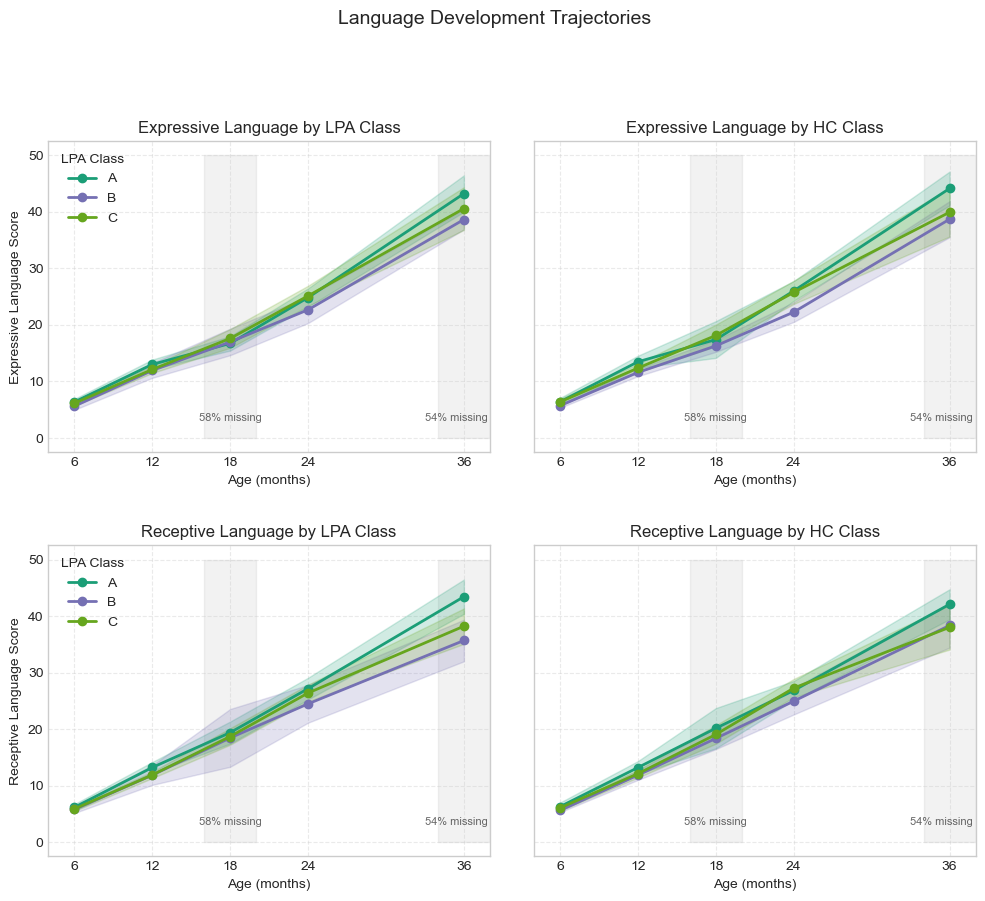

In [59]:
# Using colorblind-friendly palettes
lpa_palette = {"A": "#1b9e77", "B": "#7570b3", "C": "#66a61e"}
hc_palette = {"a": "#1b9e77", "b": "#7570b3", "c": "#66a61e"}


# Create a figure with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey='row', sharex=False)

# Plot titles
titles = [
    "Expressive Language by LPA Class", 
    "Expressive Language by HC Class",
    "Receptive Language by LPA Class", 
    "Receptive Language by HC Class"
]

# Data and class combinations to plot
plot_data = [
    (expressive_df, "LPA Class", lpa_palette),
    (expressive_df, "HC Class", hc_palette),
    (receptive_df, "LPA Class", lpa_palette),
    (receptive_df, "HC Class", hc_palette)
]

# Create all 4 plots
for i, (data, class_col, palette) in enumerate(plot_data):
    ax = axs[i//2, i%2]
    
    # Calculate means and confidence intervals for each class and age
    grouped = data.groupby([class_col, 'Age'])['score'].agg(['mean', 'sem']).reset_index()
    grouped['ci_low'] = grouped['mean'] - 1.96 * grouped['sem']
    grouped['ci_high'] = grouped['mean'] + 1.96 * grouped['sem']
    
    # Plot each class
    for class_name in sorted(data[class_col].unique()):
        group_data = grouped[grouped[class_col] == class_name]
        
        # Plot mean line
        ax.plot(group_data['Age'], group_data['mean'], 
                marker='o', markersize=6, 
                linewidth=2, label=class_name,
                color=palette[class_name])
        
        # Add confidence intervals
        ax.fill_between(group_data['Age'], 
                        group_data['ci_low'], 
                        group_data['ci_high'], 
                        alpha=0.2, color=palette[class_name])
    
    # Highlight regions with missing data
    missing_18 = Rectangle((16, 0), 4, 50, fill=True, alpha=0.1, color='gray', zorder=0)
    missing_36 = Rectangle((34, 0), 4, 50, fill=True, alpha=0.1, color='gray', zorder=0)
    ax.add_patch(missing_18)
    ax.add_patch(missing_36)
    
    # Add text indicating missing data percentage
    ax.text(18, 3, "58% missing", ha='center', fontsize=8, alpha=0.7)
    ax.text(35.4, 3, "54% missing", ha='center', fontsize=8, alpha=0.7)
    
    # Set title and labels
    ax.set_title(titles[i])
    ax.set_xlabel("Age (months)")
    
    # Set only left y-axis labels
    if i % 2 == 0:
        measure = "Expressive" if i < 2 else "Receptive"
        ax.set_ylabel(f"{measure} Language Score")

    # Configure axis
    ax.set_xlim(4, 38)
    ax.set_xticks(ages)
    
    # Add legend only for left panels
    if i % 2 == 0:
        ax.legend(title=class_col, loc='upper left')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.4)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Add a super title
fig.suptitle("Language Development Trajectories", 
             fontsize=14, y=1.12)

# Add annotation about statistical significance (example)
#fig.text(0.5, 0.01, 
 #        "* All between-group differences significant at p<0.05 based on linear mixed effects models", 
  #       ha='center', fontsize=10, style='italic')

# Save figure in high resolution
plt.savefig(f"../../Figures/Main/language_trajectories_{date}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"../../Figures/Main/language_trajectories_{date}.pdf", bbox_inches='tight')


# Show plot
plt.show()

## Individual trajectories

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\954663906.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


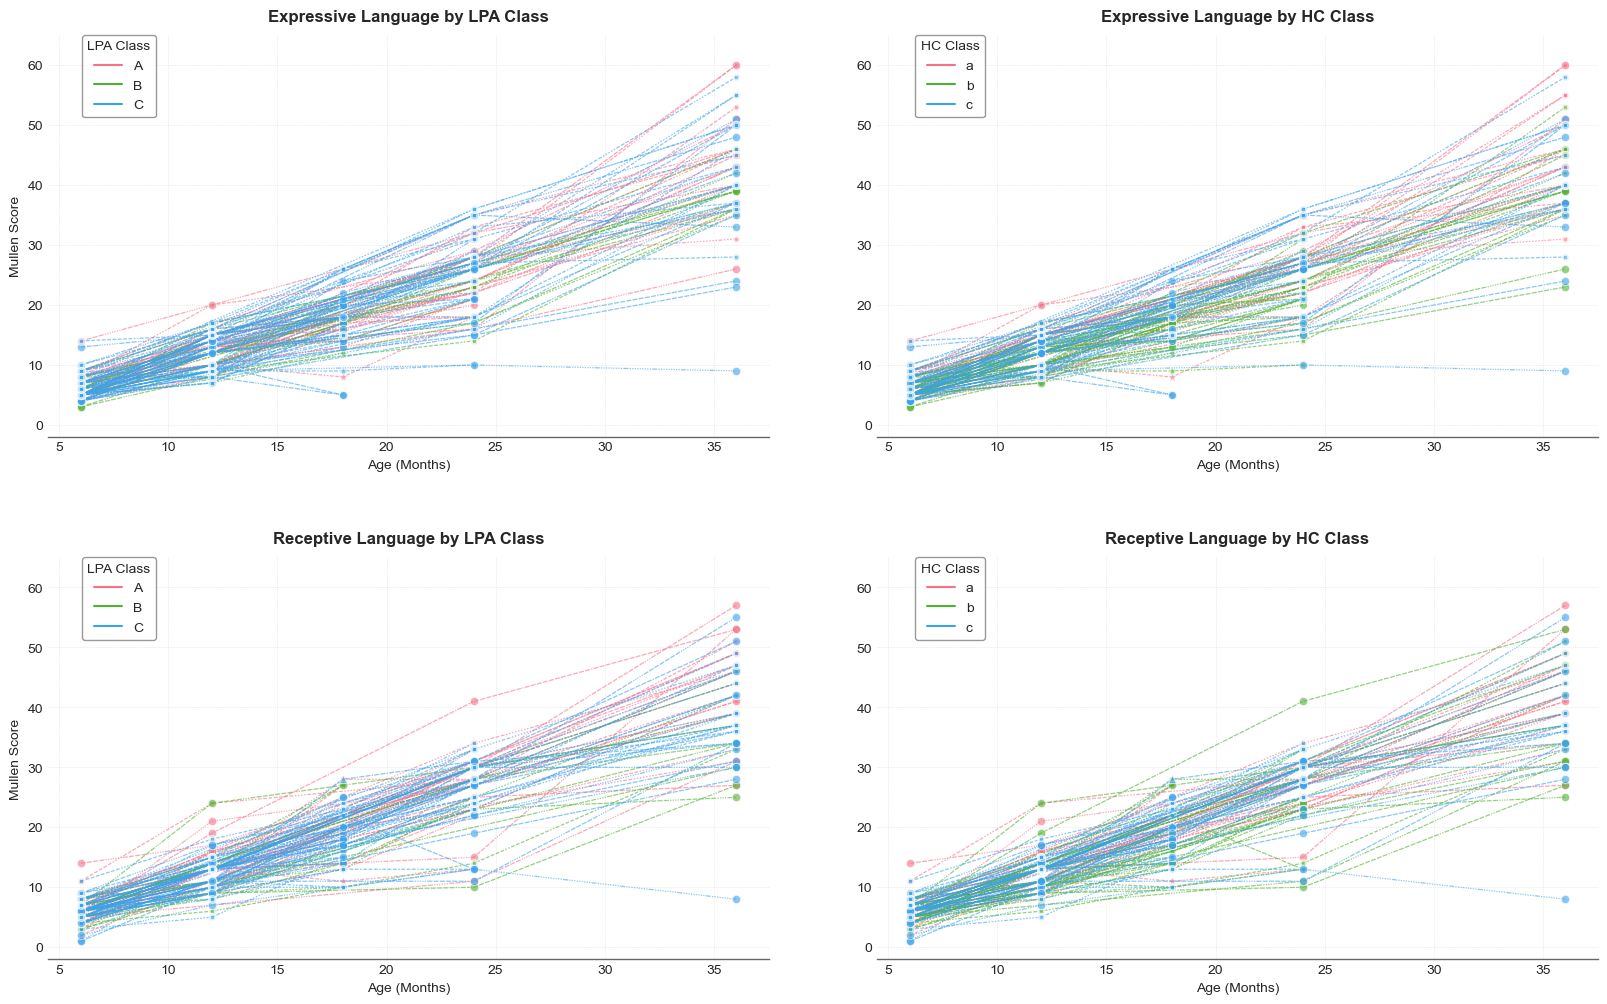

In [100]:
sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': '0.4'})
#plt.rcParams['font.family'] = 'Arial'  # Professional font
class_palette =  sns.color_palette("husl", 3)  # Can be any of : "viridis", "husl", "colorblind", "cool", "muted"
# Create figure with constrained layout
fig, axs = plt.subplots(2, 2, figsize=(20, 12), 
                        gridspec_kw={'wspace': 0.15, 'hspace': 0.3})
axs = axs.flatten()

# Use perceptually uniform palette
subject_style = {'dashes': True, 'linewidth': 0.9, 'alpha': 0.6}

# --- Plot 1: Expressive by LPA ---
g1 = sns.lineplot(data=expressive_df, x="Age", y="score", hue="LPA Class", 
                 palette=class_palette, style="subject", markers=True,
                 ax=axs[0], **subject_style)
axs[0].set_title("Expressive Language by LPA Class", pad=10, weight='bold')
axs[0].set(ylabel="Mullen Score", xlabel="Age (Months)")

# --- Plot 2: Expressive by HC ---
g2 = sns.lineplot(data=expressive_df, x="Age", y="score", hue="HC Class", 
                 palette=class_palette, style="subject", markers=True,
                 ax=axs[1], **subject_style)
axs[1].set_title("Expressive Language by HC Class", pad=10, weight='bold')
axs[1].set(ylabel="", xlabel="Age (Months)")

# --- Plot 3: Receptive by LPA ---
g3 = sns.lineplot(data=receptive_df, x="Age", y="score", hue="LPA Class", 
                palette=class_palette, style="subject", markers=True,
                ax=axs[2], **subject_style)
axs[2].set_title("Receptive Language by LPA Class", pad=10, weight='bold')
axs[2].set(ylabel="Mullen Score", xlabel="Age (Months)")

# --- Plot 4: Receptive by HC ---
g4 = sns.lineplot(data=receptive_df, x="Age", y="score", hue="HC Class", 
                palette=class_palette, style="subject", markers=True,
                ax=axs[3], **subject_style)
axs[3].set_title("Receptive Language by HC Class", pad=10, weight='bold')
axs[3].set(ylabel="", xlabel="Age (Months)")

# --- Custom Legend Handling ---
def create_combined_legend(ax, title):
    # Get all handles and labels from seaborn
    class_handles, class_labels = ax.get_legend_handles_labels()
    
    # Filter to keep only hue-related entries (e.g., only alphabetical class labels or known hue names)
    class_handles_labels = [(h, l) for h, l in zip(class_handles, class_labels)
                            if l in ['A', 'B', 'C', 'a', 'b', 'c']]  # Keep only known hue names
    # Remove duplicates while preserving order
    seen = set()
    class_handles_labels = [(h, l) for h, l in class_handles_labels if not (l in seen or seen.add(l))]

    
    # Unzip filtered pairs
    if class_handles_labels:  # Ensure list isn't empty
        class_handles, class_labels = zip(*class_handles_labels)

        # Create custom legend
        leg = ax.legend(class_handles, class_labels, title=title, 
                        frameon=True, bbox_to_anchor=(0.15, 1), 
                        borderaxespad=0.)
        leg.get_frame().set_edgecolor('0.5')
        return leg
    else:
        return None

# Add legends to each subplot
create_combined_legend(axs[0], "LPA Class")
create_combined_legend(axs[1], "HC Class")
create_combined_legend(axs[2], "LPA Class")
create_combined_legend(axs[3], "HC Class")

for ax in axs:
    # Cleaner spines
    sns.despine(ax=ax, left=True)
    
    # Add subtle grid
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
    
    # Set consistent axis limits
    ax.set_ylim(expressive_df['score'].min()-5, expressive_df['score'].max()+5)


plt.tight_layout()

# Save the figure
plt.savefig(f"../../Figures/Supplementary/{date}/individual_language_trajectories_{date}.png", dpi=300, bbox_inches='tight')
plt.show()

### **ANOVA/KRUSTAL W ANALYSES**

In [128]:

def analyze_language_data(expressive_df, receptive_df, ages=[24, 36], output_dir="../../", date=date):
    """
    Analyze language data across different age groups and classification methods.
    
    Parameters:
    -----------
    expressive_df : pandas DataFrame
        DataFrame containing expressive language scores
    receptive_df : pandas DataFrame
        DataFrame containing receptive language scores
    ages : list, optional
        List of ages (in months) to analyze
    output_dir : str, optional
        Base directory for output files
    date : str, optional
        Date string for file naming
    """
    # Create output directories if they don't exist
    tables_dir = os.path.join(output_dir, "Tables", "Supplementary", date)
    figures_dir = os.path.join(output_dir, "Figures", "Supplementary", date)
    
    for directory in [tables_dir, figures_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Initialize results file
    results_file = os.path.join(tables_dir, f"language_analysis_results_{date}.txt")
    with open(results_file, 'w') as f:
        f.write(f"Language Measures Analysis Results - {date}\n")
        f.write("="*50 + "\n\n")
    
    for age in ages:
        print(f"\nAnalyzing data for {age} months...")
        
        # Filter data for the current age
        expr_age = expressive_df[expressive_df['Age'] == age].copy()
        recp_age = receptive_df[receptive_df['Age'] == age].copy()

        # Drop nan values
        expr_age = expr_age.dropna(subset=['score'])
        recp_age = recp_age.dropna(subset=['score'])
        
        # Run analyses for all four combinations
        expr_lpa_results = analyze_group_differences(expr_age, "Expressive", "LPA", results_file)
        expr_hc_results = analyze_group_differences(expr_age, "Expressive", "HC", results_file)
        recp_lpa_results = analyze_group_differences(recp_age, "Receptive", "LPA", results_file)
        recp_hc_results = analyze_group_differences(recp_age, "Receptive", "HC", results_file)

        # Print results to console
        print(f"\nSummary of findings for {age} months:")
        for result in [expr_lpa_results, expr_hc_results, recp_lpa_results, recp_hc_results]:
            print(result)

        # Create visualizations
        create_visualization(expr_age, recp_age, age, figures_dir, date)
        
        # Create and save summary table
        create_summary_table(expr_age, recp_age, age, tables_dir, date)
    
    print(f"\nAnalysis complete. Results saved to: {tables_dir} and {figures_dir}")


def analyze_group_differences(data, measure_type, stratification, results_file):
    """
    Check ANOVA assumptions and perform appropriate statistical tests.
    
    Parameters:
    -----------
    data : pandas DataFrame
        The data to analyze
    measure_type : str
        Type of language measure (e.g., "Expressive", "Receptive")
    stratification : str
        Stratification method (e.g., "LPA", "HC")
    results_file : str
        Path to the file where results will be saved
    
    Returns:
    --------
    str
        Text summary of the analysis results
    """
    age = data['Age'].iloc[0] if not data.empty else "Unknown"
    result_text = f"\n{measure_type} Language by {stratification} Class at {age} Months\n"
    result_text += "-"*50 + "\n"
    
    # Group variable name (either "LPA Class" or "HC Class")
    group_var = f"{stratification} Class"
    
    # Check if there is sufficient data
    if data.empty or group_var not in data.columns:
        result_text += "Insufficient data for analysis.\n"
        with open(results_file, 'a') as f:
            f.write(result_text)
        return result_text
    
    # Get unique groups
    groups = data[group_var].unique()
    
    # 1. Check normality assumption for each group
    result_text += "Normality Test (Shapiro-Wilk):\n"
    all_normal = True
    
    for group in groups:
        group_data = data[data[group_var] == group]['score']
        if len(group_data) >= 3:  # Need at least 3 data points for Shapiro-Wilk
            stat, p = stats.shapiro(group_data)
            normal = p > 0.05
            all_normal = all_normal and normal
            result_text += f"  Group {group}: W={stat:.4f}, p={p:.4f}, {'Normal' if normal else 'Non-normal'}\n"
        else:
            result_text += f"  Group {group}: Insufficient data for normality test (n={len(group_data)})\n"
            all_normal = False
    
    # 2. Check homogeneity of variance
    if len(groups) >= 2:
        # Extract groups for Levene's test
        group_data = [data[data[group_var] == group]['score'].values for group in groups]
        # Remove empty groups
        group_data = [g for g in group_data if len(g) > 0]
        
        if len(group_data) >= 2:  # Need at least 2 groups for test
            stat, p = stats.levene(*group_data)
            equal_var = p > 0.05
            result_text += f"\nHomogeneity of Variance (Levene's test):\n"
            result_text += f"  W={stat:.4f}, p={p:.4f}, {'Equal variances' if equal_var else 'Unequal variances'}\n"
        else:
            equal_var = True  # Default
            result_text += "\nHomogeneity of Variance: Insufficient groups for testing\n"
    else:
        equal_var = True  # Default
        result_text += "\nHomogeneity of Variance: Insufficient groups for testing\n"
    
    # 3. Perform appropriate statistical test
    if len(groups) >= 2:
        if all_normal and equal_var:
            # Create a copy of data with renamed column for statsmodels
            temp_data = data.copy()
            # Replace spaces with underscores in column names
            temp_data.columns = [col.replace(' ', '_') for col in temp_data.columns]
            group_var_no_space = group_var.replace(' ', '_')
            
            # One-way ANOVA with renamed columns
            model = ols(f'score ~ C({group_var_no_space})', data=temp_data).fit()
            anova_results = anova_lm(model)
            
            result_text += "\nOne-way ANOVA Results:\n"
            result_text += f"  F({anova_results.loc[f'C({group_var_no_space})', 'df']:.0f}, {anova_results.loc['Residual', 'df']:.0f}) = {anova_results.loc[f'C({group_var_no_space})', 'F']:.4f}, "
            result_text += f"p = {anova_results.loc[f'C({group_var_no_space})', 'PR(>F)']:.4f}\n"
            
            # Add effect size (eta-squared)
            eta_sq = anova_results.loc[f'C({group_var_no_space})', 'sum_sq'] / (anova_results.loc[f'C({group_var_no_space})', 'sum_sq'] + anova_results.loc['Residual', 'sum_sq'])
            result_text += f"  Eta-squared = {eta_sq:.4f}\n"
            
            # If ANOVA is significant, perform post-hoc tests
            if anova_results.loc[f'C({group_var_no_space})', 'PR(>F)'] < 0.05:
                result_text += "\nPost-hoc Tests (Tukey HSD):\n"
                # For post-hoc tests, use original data and column names
                posthoc = pg.pairwise_tukey(data=data, dv='score', between=group_var)
                for idx, row in posthoc.iterrows():
                    result_text += f"  {row['A']} vs {row['B']}: diff={row['diff']:.4f}, p={row['p-tukey']:.4f}\n"
        else:
            # Kruskal-Wallis test (non-parametric alternative to ANOVA)
            valid_groups = [data[data[group_var] == group]['score'].values for group in groups if len(data[data[group_var] == group]) > 0]
            h_stat, p_val = stats.kruskal(*valid_groups)
            
            result_text += "\nKruskal-Wallis Test Results (non-parametric):\n"
            result_text += f"  H = {h_stat:.4f}, p = {p_val:.4f}\n"
            
            # If significant, perform post-hoc Dunn's test
            if p_val < 0.05:
                result_text += "\nPost-hoc Tests (Dunn's test):\n"
                try:
                    # Use dunn's test from scikit-posthocs as a safer alternative
                    from scikit_posthocs import posthoc_dunn
                    # Create a DataFrame with group labels
                    temp_df = data.copy()
                    posthoc_data = posthoc_dunn(temp_df, val_col='score', group_col=group_var, p_adjust='bonferroni')
                    
                    # Format the results
                    for i, group1 in enumerate(posthoc_data.index):
                        for j, group2 in enumerate(posthoc_data.columns):
                            if i < j:  # Only show each pair once
                                p_val = posthoc_data.iloc[i, j]
                                result_text += f"  {group1} vs {group2}: p={p_val:.4f}\n"
                except ImportError:
                    # Fallback to pingouin but handle the column naming issue
                    posthoc = pg.pairwise_tests(data=data, dv='score', between=group_var, parametric=False)
                    
                    # Debug column names
                    result_text += "  Available columns in post-hoc results: " + ", ".join(posthoc.columns.tolist()) + "\n\n"
                    
                    # Use correct column name for adjusted p-values
                    p_adj_col = 'p-corr' if 'p-corr' in posthoc.columns else 'p-adjust' if 'p-adjust' in posthoc.columns else 'p-unc'
                    
                    for idx, row in posthoc.iterrows():
                        result_text += f"  {row['A']} vs {row['B']}: p={row[p_adj_col]:.4f}\n"
    else:
        result_text += "\nInsufficient groups for statistical comparison\n"
    
    # 4. Descriptive statistics
    result_text += "\nDescriptive Statistics:\n"
    desc_stats = data.groupby(group_var)['score'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    for _, row in desc_stats.iterrows():
        result_text += f"  Group {row[group_var]}: n={row['count']}, Mean={row['mean']:.2f}, SD={row['std']:.2f}, Range={row['min']:.2f}-{row['max']:.2f}\n"
    
    # Write to file
    with open(results_file, 'a') as f:
        f.write(result_text)
    
    return result_text


def create_visualization(expr_data, recp_data, age, figures_dir, date):
    """
    Create and save visualization of language scores by group.
    
    Parameters:
    -----------
    expr_data : pandas DataFrame
        DataFrame containing expressive language scores
    recp_data : pandas DataFrame
        DataFrame containing receptive language scores
    age : int
        Age in months
    figures_dir : str
        Directory where figures will be saved
    date : str
        Date string for file naming
    """
    # Set up professional style - use a safer approach
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Use a colorblind-friendly palette
    class_palette = sns.color_palette("viridis", n_colors=3)  # Can be any of : "viridis", "husl", "colorblind", "cool
    
    # Create figure with constrained layout
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

    # Add more spece between subplots   
    fig.subplots_adjust(hspace=0.3, wspace=0.2, top=0.9)
    axs = axs.flatten()
    
    # Create boxplots
    create_boxplot(axs[0], expr_data, "LPA Class", f"Expressive Language by LPA Class at {age} Months", class_palette)
    create_boxplot(axs[1], expr_data, "HC Class", f"Expressive Language by HC Class at {age} Months", class_palette)
    create_boxplot(axs[2], recp_data, "LPA Class", f"Receptive Language by LPA Class at {age} Months", class_palette)
    create_boxplot(axs[3], recp_data, "HC Class", f"Receptive Language by HC Class at {age} Months", class_palette)
    
    # Add figure title
    fig.suptitle(f"Language Scores at {age} Months by Classification Method", 
                fontsize=15, weight='bold', y=1.08)
    
    # Save the figure
    output_file = os.path.join(figures_dir, f"language_analysis_{age}months_{date}.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    try:
        plt.savefig(output_file.replace('.png', '.pdf'), format='pdf', bbox_inches='tight')  # Also save as PDF for publication
    except Exception as e:
        print(f"Warning: Could not save PDF version: {e}")
    plt.close()
    
    print(f"Created visualization: {output_file}")


def create_boxplot(ax, data, group_var, title, palette):
    """
    Create a boxplot with data points for a specific group variable.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    data : pandas DataFrame
        The data to plot
    group_var : str
        The grouping variable
    title : str
        The title for the plot
    palette : list
        Color palette to use
    """
    if group_var not in data.columns or data.empty:
        ax.text(0.5, 0.5, "Insufficient data", ha='center', va='center', fontsize=12)
        ax.set_title(title)
        return
    
    # Create boxplot with individual data points
    sns.boxplot(x=group_var, y='score', data=data, palette=palette, ax=ax, width=0.5, fliersize=0)
    sns.stripplot(x=group_var, y='score', data=data, palette=palette, ax=ax, 
                dodge=True, alpha=0.7, jitter=0.2, marker='o', edgecolor='black', linewidth=0.5)
    
    # Set title and labels
    ax.set_title(title, pad=10)
    ax.set_ylabel("Mullen Score")
    ax.set_xlabel("")
    
    # Add statistics annotation
    add_stats_annotation(ax, data, group_var)
    
    # Clean up plot
    sns.despine(ax=ax)
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)


def add_stats_annotation(ax, data, group_var):
    """
    Add statistical annotation to a plot.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to annotate
    data : pandas DataFrame
        The data used in the plot
    group_var : str
        The grouping variable
    """
    # Get number of groups
    groups = data[group_var].unique()
    
    # Prepare annotation text based on test results
    if len(groups) >= 2:
        # Extract data for statistical test
        group_data = [data[data[group_var] == group]['score'].values for group in groups if len(data[data[group_var] == group]) > 0]
        
        # Check normality and homogeneity
        try:
            normal = all([stats.shapiro(g)[1] > 0.05 for g in group_data if len(g) >= 3])
        except:
            normal = False  # Default to non-parametric if there's an issue
            
        if len(group_data) >= 2:
            try:
                equal_var = stats.levene(*group_data)[1] > 0.05
            except:
                equal_var = False  # Default to non-parametric if there's an issue
        else:
            equal_var = True
        
        # Run appropriate test
        if normal and equal_var:
            # One-way ANOVA - using renamed columns to avoid space issues
            try:
                temp_data = data.copy()
                temp_data.columns = [col.replace(' ', '_') for col in temp_data.columns]
                group_var_no_space = group_var.replace(' ', '_')
                
                model = ols(f'score ~ C({group_var_no_space})', data=temp_data).fit()
                anova_table = anova_lm(model)
                p_val = anova_table.loc[f'C({group_var_no_space})', 'PR(>F)']
                test_name = "ANOVA"
                test_stat = f"F={anova_table.loc[f'C({group_var_no_space})', 'F']:.2f}"
            except Exception as e:
                # Fall back to Kruskal-Wallis if ANOVA fails
                try:
                    h_stat, p_val = stats.kruskal(*group_data)
                    test_name = "Kruskal-Wallis"
                    test_stat = f"H={h_stat:.2f}"
                except:
                    p_val = np.nan
                    test_name = "Error"
                    test_stat = ""
        else:
            # Kruskal-Wallis
            try:
                h_stat, p_val = stats.kruskal(*group_data)
                test_name = "Kruskal-Wallis"
                test_stat = f"H={h_stat:.2f}"
            except:
                p_val = np.nan
                test_name = "Error"
                test_stat = ""
        
        # Format annotation based on significance
        if not pd.isna(p_val):
            if p_val < 0.001:
                sig_text = f"{test_name}: {test_stat}, p<0.001 ***"
            elif p_val < 0.01:
                sig_text = f"{test_name}: {test_stat}, p<0.01 **"
            elif p_val < 0.05:
                sig_text = f"{test_name}: {test_stat}, p<0.05 *"
            else:
                sig_text = f"{test_name}: {test_stat}, p={p_val:.3f} ns"
        else:
            sig_text = f"{test_name}: Could not calculate"
            
        # Add text to plot
        ax.text(0.5, 0.98, sig_text, transform=ax.transAxes, 
                ha='center', va='top', fontsize=9, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))


def create_summary_table(expr_data, recp_data, age, tables_dir, date):
    """
    Create and save a summary table of results.
    
    Parameters:
    -----------
    expr_data : pandas DataFrame
        DataFrame containing expressive language scores
    recp_data : pandas DataFrame
        DataFrame containing receptive language scores
    age : int
        Age in months
    tables_dir : str
        Directory where tables will be saved
    date : str
        Date string for file naming
    """
    summary_data = []

    for df, measure, strat in [(expr_data, "Expressive", "LPA"), 
                              (expr_data, "Expressive", "HC"),
                              (recp_data, "Receptive", "LPA"),
                              (recp_data, "Receptive", "HC")]:
        
        group_var = f"{strat} Class"
        
        # Skip if data is insufficient
        if group_var not in df.columns or df.empty:
            continue
            
        # Get descriptive stats by group
        desc = df.groupby(group_var)['score'].agg(['count', 'mean', 'std']).reset_index()
        
        # Get statistical test results
        groups = df[group_var].unique()
        test_stat = np.nan
        p_val = np.nan
        test_type = "N/A"
        df_val = np.nan
        
        if len(groups) >= 2:
            # Extract data for test
            group_data = [df[df[group_var] == group]['score'].values for group in groups if len(df[df[group_var] == group]) > 0]
            
            # Check normality and homogeneity
            try:
                normal = all([stats.shapiro(g)[1] > 0.05 for g in group_data if len(g) >= 3])
            except:
                normal = False
                
            if len(group_data) >= 2:
                try:
                    equal_var = stats.levene(*group_data)[1] > 0.05
                except:
                    equal_var = False
            else:
                equal_var = True
            
            # Run appropriate test
            if normal and equal_var:
                try:
                    # ANOVA - using renamed columns to avoid space issues
                    temp_data = df.copy()
                    temp_data.columns = [col.replace(' ', '_') for col in temp_data.columns]
                    group_var_no_space = group_var.replace(' ', '_')
                    
                    model = ols(f'score ~ C({group_var_no_space})', data=temp_data).fit()
                    test_results = anova_lm(model)
                    p_val = test_results.loc[f'C({group_var_no_space})', 'PR(>F)']
                    test_stat = test_results.loc[f'C({group_var_no_space})', 'F']
                    test_type = "ANOVA (F)"
                    df_val = f"{test_results.loc[f'C({group_var_no_space})', 'df']:.0f}, {test_results.loc['Residual', 'df']:.0f}"
                except:
                    # Fall back to Kruskal-Wallis
                    try:
                        test_stat, p_val = stats.kruskal(*group_data)
                        test_type = "Kruskal-Wallis (H)"
                        df_val = len(groups) - 1  # df for Kruskal-Wallis is k-1
                    except:
                        test_stat = np.nan
                        p_val = np.nan
                        test_type = "Error in analysis"
            else:
                # Kruskal-Wallis
                try:
                    test_stat, p_val = stats.kruskal(*group_data)
                    test_type = "Kruskal-Wallis (H)"
                    df_val = len(groups) - 1  # df for Kruskal-Wallis is k-1
                except:
                    test_stat = np.nan
                    p_val = np.nan
                    test_type = "Error in analysis"
        
        # Add to summary data
        for _, row in desc.iterrows():
            summary_data.append({
                'Age': age,
                'Measure': measure,
                'Stratification': strat,
                'Group': row[group_var],
                'N': row['count'],
                'Mean': row['mean'],
                'SD': row['std'],
                'Test': test_type if _ == 0 else "",  # Only include test info once per stratification
                'df': df_val if _ == 0 else np.nan,
                'Statistic': test_stat if _ == 0 else np.nan,
                'p-value': p_val if _ == 0 else np.nan,
                'Significance': get_significance_marker(p_val) if _ == 0 else ""
            })

    # Create and save summary table
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        
        # Format numeric columns
        summary_df['Mean'] = summary_df['Mean'].round(2)
        summary_df['SD'] = summary_df['SD'].round(2)
        summary_df['Statistic'] = summary_df['Statistic'].apply(lambda x: round(x, 2) if pd.notnull(x) else x)
        
        # Format p-values
        summary_df['p-value'] = summary_df['p-value'].apply(lambda x: format_p_value(x) if not pd.isna(x) else x)
        
        # Save as CSV
        output_file = os.path.join(tables_dir, f"Language_analysis_summary_{age}mo_{date}.csv")
        #summary_df.to_csv(output_file, index=False)
        
        # Also save as Excel for easier editing
        try:
            summary_df.to_excel(output_file.replace('.csv', '.xlsx'), index=False)
        except:
            print(f"Warning: Could not save Excel file. Make sure openpyxl is installed.")
        
        print(f"Created summary table: {output_file}")
    else:
        print(f"Insufficient data to create summary table for age {age} months")


def get_significance_marker(p_value):
    """Return significance marker based on p-value."""
    if pd.isna(p_value):
        return ""
    elif p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"


def format_p_value(p_value):
    """Format p-value for reporting."""
    if pd.isna(p_value):
        return ""
    elif p_value < 0.001:
        return "<0.001"
    else:
        return f"{p_value:.3f}"
analyze_language_data(expressive_df, receptive_df, ages=[12,24, 36], output_dir="../../", date=date)


Analyzing data for 12 months...



Summary of findings for 12 months:

Expressive Language by LPA Class at 12 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group A: W=0.9474, p=0.0568, Normal
  Group C: W=0.9441, p=0.0039, Non-normal
  Group B: W=0.9586, p=0.5455, Normal

Homogeneity of Variance (Levene's test):
  W=0.0062, p=0.9938, Equal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 2.4537, p = 0.2932

Descriptive Statistics:
  Group A: n=41, Mean=13.02, SD=2.80, Range=8.00-20.00
  Group B: n=19, Mean=11.95, SD=2.90, Range=7.00-17.00
  Group C: n=69, Mean=12.13, SD=2.68, Range=7.00-17.00


Expressive Language by HC Class at 12 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group b: W=0.9647, p=0.1738, Normal
  Group c: W=0.9356, p=0.0090, Non-normal
  Group a: W=0.9366, p=0.0541, Normal

Homogeneity of Variance (Levene's test):
  W=1.6352, p=0.1990, Equal variances

Kruskal-Wallis Test Results (non-parametric):
 

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\2634984557.py:241: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.3, wspace=0.2, top=0.9)


Created visualization: ../../Figures\Supplementary\2025_04_23\language_analysis_12months_2025_04_23.png
Created summary table: ../../Tables\Supplementary\2025_04_23\Language_analysis_summary_12mo_2025_04_23.csv

Analyzing data for 24 months...

Summary of findings for 24 months:

Expressive Language by LPA Class at 24 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group A: W=0.9713, p=0.4972, Normal
  Group C: W=0.9540, p=0.0402, Non-normal
  Group B: W=0.9014, p=0.1399, Normal

Homogeneity of Variance (Levene's test):
  W=1.9681, p=0.1453, Equal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 2.6900, p = 0.2605

Descriptive Statistics:
  Group A: n=34, Mean=24.85, SD=4.84, Range=16.00-35.00
  Group B: n=13, Mean=22.69, SD=4.33, Range=14.00-28.00
  Group C: n=53, Mean=25.15, SD=6.66, Range=10.00-36.00


Expressive Language by HC Class at 24 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\2634984557.py:241: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.3, wspace=0.2, top=0.9)


Created visualization: ../../Figures\Supplementary\2025_04_23\language_analysis_24months_2025_04_23.png
Created summary table: ../../Tables\Supplementary\2025_04_23\Language_analysis_summary_24mo_2025_04_23.csv

Analyzing data for 36 months...

Summary of findings for 36 months:

Expressive Language by LPA Class at 36 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
  Group C: W=0.9436, p=0.1136, Normal
  Group B: W=0.8836, p=0.0975, Normal
  Group A: W=0.9686, p=0.6336, Normal

Homogeneity of Variance (Levene's test):
  W=4.0953, p=0.0213, Unequal variances

Kruskal-Wallis Test Results (non-parametric):
  H = 4.1061, p = 0.1283

Descriptive Statistics:
  Group A: n=24, Mean=43.25, SD=8.08, Range=26.00-60.00
  Group B: n=12, Mean=38.67, SD=3.08, Range=35.00-46.00
  Group C: n=30, Mean=40.60, SD=10.54, Range=9.00-58.00


Expressive Language by HC Class at 36 Months
--------------------------------------------------
Normality Test (Shapiro-Wilk):
 

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\2634984557.py:241: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.3, wspace=0.2, top=0.9)


Created visualization: ../../Figures\Supplementary\2025_04_23\language_analysis_36months_2025_04_23.png
Created summary table: ../../Tables\Supplementary\2025_04_23\Language_analysis_summary_36mo_2025_04_23.csv

Analysis complete. Results saved to: ../../Tables\Supplementary\2025_04_23 and ../../Figures\Supplementary\2025_04_23


### **Correlation Language and EEG Variables**

In [129]:
expressive_vars = ['expressive_6', 'expressive_12', 'expressive_24', 'expressive_36']
receptive_vars= ['receptive_6', 'receptive_12', 'receptive_24', 'receptive_36']

#### Expressive

In [130]:
# Create correlation matrix of language measures and connectivity measures

# Select the columns to include in the correlation matrix (select only expressive language measures)
columns = eeg_vars + expressive_vars

corr_df = neurosubs_df[columns]
# Rename the columns based on mapping
corr_df.rename(columns=clean_column_name_mapping, inplace=True)

# Create the correlation matrix
corr_matrix = corr_df.corr().round(2)

# Calculate p-values for the correlation matrix
from scipy.stats import pearsonr

def calculate_p_values(df):
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i != j:
                _, p_value = pearsonr(df.iloc[:, i], df.iloc[:, j])
                p_values.iloc[i, j] = p_value
            else:
                p_values.iloc[i, j] = 0  # Set diagonal to 0
    return p_values
p_values = calculate_p_values(corr_df)


# Plot the correlation matrix (only the lower tri)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="vlag", center=0, vmin=-1, vmax=1, square=True, mask=np.triu(corr_matrix))
# Add * for p-values < 0.05
for i in range(len(p_values.columns)):
    for j in range(len(p_values.columns)):
        if p_values.iloc[i, j] < 0.05 and i != j:
            plt.text(j + 0.5, i + 0.5, "*", color="black", ha="center", va="center", fontsize=16)
plt.title("Correlation Matrix of Expressive and EEG Measures")
plt.show()



C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\1693576185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df.rename(columns=clean_column_name_mapping, inplace=True)


ValueError: array must not contain infs or NaNs

In [ ]:
# Plot 1: Expressive variables correlation matrix
expressive_columns = eeg_vars + expressive_vars
expressive_corr_df = neurosubs_df[expressive_columns].rename(columns=clean_column_name_mapping)

# Calculate correlation matrix with NAs dropped pairwise
expressive_corr_matrix = expressive_corr_df.corr(method='pearson', min_periods=1).round(2)
expressive_p_values = calculate_p_values(expressive_corr_df)

# Choose the significance highlighting method: 'bold', 'border' or 'size'
significance_method = 'border'

plot_correlation_matrix(
    expressive_corr_matrix, 
    expressive_p_values, 
    "Correlation Matrix of Expressive Language and EEG Measures",
    significance_method
)
plt.show()

# Plot 2: Receptive variables correlation matrix
receptive_columns = eeg_vars + receptive_vars
receptive_corr_df = neurosubs_df[receptive_columns].rename(columns=clean_column_name_mapping)

# Calculate correlation matrix with NAs dropped pairwise
receptive_corr_matrix = receptive_corr_df.corr(method='pearson', min_periods=1).round(2)
receptive_p_values = calculate_p_values(receptive_corr_df)

plot_correlation_matrix(
    receptive_corr_matrix, 
    receptive_p_values, 
    "Correlation Matrix of Receptive Language and EEG Measures",
    significance_method
)
plt.show()

TypeError: plot_correlation_matrix() takes 3 positional arguments but 4 were given

In [324]:
corr_df

,auditory_con_6,lang_comp_con_6,speech_con_6_left,front_gamma_6,gamma_lat_6,receptive_6,expressive_6,receptive_12,expressive_12,receptive_18,...,receptive_18,expressive_18,receptive_24,expressive_24,receptive_36,expressive_36,expressive_6,expressive_12,expressive_24,expressive_36
0,-1.598480,-1.161137,-1.225266,-21.420116,NaN,5.0,5.0,13.0,13.0,22.0,...,22.0,14.0,28.0,21.0,NaN,NaN,5.0,13.0,21.0,NaN
1,-1.829292,-1.516043,-1.659758,-21.072590,0.040530,8.0,7.0,14.0,14.0,20.0,...,20.0,18.0,27.0,21.0,NaN,NaN,7.0,14.0,21.0,NaN
2,-1.823852,-1.619339,-1.464546,-22.141673,-0.016544,6.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
3,-1.429544,-1.602488,-1.757113,-21.630370,-0.164802,6.0,4.0,13.0,12.0,20.0,...,20.0,21.0,28.0,27.0,NaN,NaN,4.0,12.0,27.0,NaN
4,-1.765373,-1.587519,-1.432471,-21.588120,-0.108383,6.0,5.0,11.0,8.0,20.0,...,20.0,21.0,28.0,24.0,NaN,NaN,5.0,8.0,24.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-1.788839,-1.603515,-1.522898,-20.919022,0.042839,5.0,5.0,13.0,15.0,NaN,...,NaN,NaN,28.0,24.0,NaN,NaN,5.0,15.0,24.0,NaN
140,-1.071994,-1.285763,-1.526620,-21.463387,-0.097921,8.0,5.0,13.0,10.0,27.0,...,27.0,21.0,NaN,NaN,NaN,NaN,5.0,10.0,NaN,NaN
141,-1.762447,-1.702147,-1.740539,-21.106285,NaN,7.0,6.0,8.0,10.0,13.0,...,13.0,15.0,NaN,NaN,NaN,NaN,6.0,10.0,NaN,NaN
142,-1.490023,-1.357769,-1.000501,NaN,-0.088992,6.0,5.0,11.0,12.0,20.0,...,20.0,18.0,NaN,NaN,NaN,NaN,5.0,12.0,NaN,NaN


In [283]:
corr_df

,Connectivity Auditory Network,Connectivity Language,Connectivity Speech,Frontal Gamma Power,Power Lateralization,receptive_6,MSEL 6 months,receptive_12,MSEL 12 months,receptive_18,...,receptive_6,MSEL 6 months,receptive_12,MSEL 12 months,receptive_18,MSEL 18 months,receptive_24,MSEL 24 months,receptive_36,MSEL 36 months
0,-1.598480,-1.161137,-1.225266,-21.420116,NaN,5.0,5.0,13.0,13.0,22.0,...,5.0,5.0,13.0,13.0,22.0,14.0,28.0,21.0,NaN,NaN
1,-1.829292,-1.516043,-1.659758,-21.072590,0.040530,8.0,7.0,14.0,14.0,20.0,...,8.0,7.0,14.0,14.0,20.0,18.0,27.0,21.0,NaN,NaN
2,-1.823852,-1.619339,-1.464546,-22.141673,-0.016544,6.0,5.0,NaN,NaN,NaN,...,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.429544,-1.602488,-1.757113,-21.630370,-0.164802,6.0,4.0,13.0,12.0,20.0,...,6.0,4.0,13.0,12.0,20.0,21.0,28.0,27.0,NaN,NaN
4,-1.765373,-1.587519,-1.432471,-21.588120,-0.108383,6.0,5.0,11.0,8.0,20.0,...,6.0,5.0,11.0,8.0,20.0,21.0,28.0,24.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-1.788839,-1.603515,-1.522898,-20.919022,0.042839,5.0,5.0,13.0,15.0,NaN,...,5.0,5.0,13.0,15.0,NaN,NaN,28.0,24.0,NaN,NaN
140,-1.071994,-1.285763,-1.526620,-21.463387,-0.097921,8.0,5.0,13.0,10.0,27.0,...,8.0,5.0,13.0,10.0,27.0,21.0,NaN,NaN,NaN,NaN
141,-1.762447,-1.702147,-1.740539,-21.106285,NaN,7.0,6.0,8.0,10.0,13.0,...,7.0,6.0,8.0,10.0,13.0,15.0,NaN,NaN,NaN,NaN
142,-1.490023,-1.357769,-1.000501,NaN,-0.088992,6.0,5.0,11.0,12.0,20.0,...,6.0,5.0,11.0,12.0,20.0,18.0,NaN,NaN,NaN,NaN


## Archive

In [ ]:
graphing_df = plotting_df.copy()

hc_order = ["a", "b", "c"]
lpa_order = ["A", "B", "C"]

# Create two separate dataframes for each class
hc_graph_df = graphing_df[graphing_df["HC Class"].isin(hc_order)]
mp_graph_df = graphing_df[graphing_df["LPA Class"].isin(lpa_order)]

# Sort the each column for each dataframe by the specified order
hc_graph_df["HC Class"] = pd.Categorical(hc_graph_df["HC Class"], categories=hc_order, ordered=True)
mp_graph_df["LPA Class"] = pd.Categorical(mp_graph_df["LPA Class"], categories=lpa_order, ordered=True)


layout = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "H"],
    ["I", "J"]]
fig, axd = plt.subplot_mosaic(layout, figsize=(25, 50))

# Add main title
fig.suptitle('Demographic characteristics by HC Class and LPA Class', fontsize=16)

# Function to plot for a given class and axis
def plot_class_distribution(df, class_col, ax, title, order):
    sns.barplot(x=df[class_col].value_counts().index, y=df[class_col].value_counts().values, palette="Set2", ax=ax, order=order)
    # add ylims
    ax.set_title(title)
    ax.set_xlabel(class_col)
    ax.set_ylabel("Number of participants")
    ax.set_ylim(0, 120)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
    )

# Plot 1 & 2 for HC Class and LPA Class size
plot_class_distribution(hc_graph_df, 'HC Class', axd["A"], "HC Class Size", hc_order)
plot_class_distribution(graphing_df, 'LPA Class', axd["B"], "LPA Class Size", lpa_order)

# Function to plot proportion of ASD with specified order
def plot_proportion_asd(df, class_col, ax, order):
    # Group by the specified class column and calculate outcome proportions
    outcome_dist = df.groupby(class_col)["ASD Diagnosis"].value_counts().unstack().reset_index().fillna(0)
    outcome_dist["total"] = outcome_dist["asd"] + outcome_dist["no-asd"]
    outcome_dist["asd"] = outcome_dist["asd"] / outcome_dist["total"]

    # Sort the outcome distribution by the specified order
    outcome_dist = outcome_dist.set_index(class_col).loc[order].reset_index()

    sns.barplot(x=outcome_dist[class_col], y=outcome_dist["asd"], palette="Blues", ax=ax)
    ax.set_title(f"Proportion of ASD in each {class_col}")
    ax.set_xlabel(class_col)
    ax.set_ylim(0, 0.5)

    ax.set_ylabel("Percentage ASD in study (%)")

# Plot 3 & 4 for proportions with the specified order
plot_proportion_asd(hc_graph_df, 'HC Class', axd["C"], hc_order)
plot_proportion_asd(mp_graph_df, 'LPA Class', axd["D"], lpa_order)

# Function for stacked distributions
def plot_stacked_distribution(df, class_col, ax, colors, title):
    dist = df.groupby(class_col)["ASD Likelihood"].value_counts().unstack().reset_index().fillna(0)
    dist["total"] = dist["ELA"] + dist["TLA"]
    dist["ELA"] = dist["ELA"] / dist["total"]
    dist["TLA"] = dist["TLA"] / dist["total"]
    dist.index = dist[class_col]
    dist.drop(columns=[class_col, "total"], inplace=True)
    dist.plot(kind="bar", stacked=True, color=colors, ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 1.3)
    ax.legend(title="Outcome", loc='upper left', labels=['ELA', 'TLA'], ncol=2)

# Plot stacked distributions for outcomes
plot_stacked_distribution(hc_graph_df, 'HC Class', axd["E"], ['salmon','skyblue'], "Proportion of Outcomes by HC Class")
plot_stacked_distribution(mp_graph_df, 'LPA Class', axd["F"], ['salmon','skyblue'], "Proportion of Outcomes by MP Class")

# Plot 5: Distribution of sex in each class
def plot_sex_distribution(df, class_col, ax):
    sex_dist = df.groupby(class_col)["Sex"].value_counts().unstack().reset_index().fillna(0)
    sex_dist["total"] = sex_dist["F"] + sex_dist["M"]
    sex_dist["F"] = sex_dist["F"] / sex_dist["total"]
    sex_dist["M"] = sex_dist["M"] / sex_dist["total"]
    sex_dist.index = sex_dist[class_col]
    sex_dist.drop(columns=[class_col, "total"], inplace=True)
    sex_dist.plot(kind="bar", stacked=True, color=['firebrick', 'steelblue'], ax=ax)
    ax.set_title(f"Sex Distribution by {class_col}")
    ax.set_ylim(0, 1.3)
    ax.legend(title="Sex", loc='upper right')

# Plot 5 & 6 for sex distribution
plot_sex_distribution(hc_graph_df, 'HC Class', axd["G"])
plot_sex_distribution(mp_graph_df, 'LPA Class', axd["H"])

# Plot 7: Site distribution in each class
def plot_site_distribution(df, class_col, ax):
    site_dist = df.groupby(class_col)["Site"].value_counts().unstack().reset_index().fillna(0)
    site_dist["total"] = site_dist["london"] + site_dist["washington"]
    site_dist["london"] = site_dist["london"] / site_dist["total"]
    site_dist["washington"] = site_dist["washington"] / site_dist["total"]
    site_dist.index = site_dist[class_col]
    site_dist.drop(columns=[class_col, "total"], inplace=True)
    site_dist.plot(kind="bar", stacked=True, color=['darkorange', 'darkblue'], ax=ax)
    ax.set_title(f"Site Distribution by {class_col}")
    ax.set_ylim(0, 1.3)
    ax.legend(title="Site", loc='upper right')

# Plot 7 & 8 for site distribution
plot_site_distribution(hc_graph_df, 'HC Class', axd["I"])
plot_site_distribution(mp_graph_df, 'LPA Class', axd["J"])

# Final adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Make 4 subplots, one for each language measure (expressive vs receptive) and for for type of stratification (HC Class vs LPA Class)

custom_palette = sns.color_palette("Set1", n_colors=3)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array

# Plot the distribution of the LPA classes
sns.lineplot(data=expressive_df, x="Age", y="score", hue="LPA Class", ax=axs[0], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[0].get_legend().remove()
axs[0].set_title("Expressive Language Measures by LPA Class")
axs[0].set_ylabel("Mullen Score")
axs[0].set_xlabel("Age (Months)")

# Plot the distribution of the HC classes
sns.lineplot(data=expressive_df, x="Age", y="score", hue="HC Class", ax=axs[1], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[1].get_legend().remove()
axs[1].set_title("Expressive Language Measures by HC Class")
axs[1].set_ylabel("Mullen Score")
axs[1].set_xlabel("Age (Months)")

# Plot the distribution of the LPA classes
sns.lineplot(data=receptive_df, x="Age", y="score", hue="LPA Class", ax=axs[2], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[2].get_legend().remove()
axs[2].set_title("Receptive Language Measures by LPA Class")
axs[2].set_ylabel("Mullen Score")
axs[2].set_xlabel("Age (Months)")

# Plot the distribution of the HC classes
sns.lineplot(data=receptive_df, x="Age", y="score", hue="HC Class", ax=axs[3], palette=custom_palette, style="subject", markers=True, dashes=True)
axs[3].get_legend().remove()
axs[3].set_title("Receptive Language Measures by HC Class")
axs[3].set_ylabel("Mullen Score")
axs[3].set_xlabel("Age (Months)")

# Adjust the layout
plt.tight_layout()


plt.show()

## **Claude solutions**

In [142]:
og_plotting_df = plotting_df.copy()

In [157]:
# Complete EEG Class Visualization Suite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib as mpl

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

# Define a consistent color palette (blue-green spectrum)
cluster_colors = {
    0: '#184e77',  # deep blue
    1: '#1a759f',  # mid blue-teal
    2: '#34a0a4',  # bright teal
}

# Assume plotting_df contains your data with columns for the 5 EEG measures
# and classification columns 'LPA Class' and 'HC Class'
# For demonstration, we'll generate sample data if needed

# Sample data generation for demonstration (replace with your actual data)
def generate_sample_data(n_samples=144):
    np.random.seed(42)
    measures = ["Connectivity Speech", "Connectivity Auditory Network", 
                "Frontal Gamma Power", "Power Lateralization", "Connectivity Language"]
    
    # Create distinct patterns for 3 clusters
    base_values = {
        0: [0.7, 0.3, 0.8, 0.2, 0.6],  # Class 1 tendencies
        1: [0.3, 0.8, 0.4, 0.7, 0.3],  # Class 2 tendencies
        2: [0.5, 0.5, 0.2, 0.5, 0.9],  # Class 3 tendencies
    }
    
    # Assign LPA classes with some noise
    lpa_classes = np.random.choice([0, 1, 2], size=n_samples, p=[0.33, 0.33, 0.34])
    
    # HC classes will be similar but with some disagreement
    hc_classes = np.copy(lpa_classes)
    # Add some disagreement between methods (about 20%)
    disagreement_idx = np.random.choice(range(n_samples), size=int(n_samples*0.2), replace=False)
    for idx in disagreement_idx:
        current = hc_classes[idx]
        options = [i for i in [0, 1, 2] if i != current]
        hc_classes[idx] = np.random.choice(options)
    
    # Generate feature values based on class with noise
    data = []
    for i in range(n_samples):
        # Create feature values with noise for LPA class
        lpa_features = [base_values[lpa_classes[i]][j] + np.random.normal(0, 0.2) for j in range(5)]
        # Ensure values are in reasonable range
        lpa_features = [max(0, min(1, val)) for val in lpa_features]
        
        # Create row with both LPA and HC classifications
        row = dict(zip(measures, lpa_features))
        row['LPA Class'] = lpa_classes[i]
        row['HC Class'] = hc_classes[i]
        
        data.append(row)
    
    return pd.DataFrame(data)

# Use actual data or generate sample

plotting_df = generate_sample_data(144)
plotting_df= og_plotting_df.copy()

# Drop any rows with NaN values in the measures
plotting_df.dropna(subset= clean_eeg_vars, how="any", inplace=True)

# Clean EEG variables - extract from your data or define manually
measures = ["Connectivity Speech", "Connectivity Auditory Network", 
            "Frontal Gamma Power", "Power Lateralization", "Connectivity Language"]

# Create normalized dataframe for consistent scaling
normalized_df = plotting_df.copy()
for var in measures:
    normalized_df[var] = (normalized_df[var] - normalized_df[var].mean()) / normalized_df[var].std()

# Calculate cluster profiles (means)
profiles_hc = normalized_df.groupby("HC Class").mean()[measures]
profiles_lpa = normalized_df.groupby("LPA Class").mean()[measures]

# Get cluster sizes for annotation
hc_sizes = plotting_df.groupby("HC Class").size()
lpa_sizes = plotting_df.groupby("LPA Class").size()

# Add cluster sizes to profiles
for i in profiles_hc.index:
    profiles_hc.loc[i, 'size'] = hc_sizes[i]
for i in profiles_lpa.index:
    profiles_lpa.loc[i, 'size'] = lpa_sizes[i]

###########################################
# 1. RADAR/SPIDER PLOTS
###########################################

def radar_plot(profiles, method_name, colors=cluster_colors):
    """Create radar plot for cluster profiles"""
    # Set up the radar plot
    fig = plt.figure(figsize=(10, 8))
    
    # Count clusters
    n_clusters = len(profiles.index)
    
    # Number of variables we're plotting
    categories = measures
    n_vars = len(categories)
    
    # Set up the angle for each variable
    angles = np.linspace(0, 2*np.pi, n_vars, endpoint=False).tolist()
    # Make the plot circular
    angles += angles[:1]
    
    # Set up the axes
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Add labels to the plot
    plt.xticks(angles[:-1], categories, fontsize=14)
    
    # Set y-axis limits for better comparison
    ax.set_ylim(-2.5, 2.5)
    # Set up labels on y-axis
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(['-2', '-1', '0', '+1', '+2'])
    
    # Plot each cluster profile
    for i, cluster in enumerate(profiles.index):
        cluster_values = profiles.loc[cluster, categories].values.tolist()
        # Close the loop
        cluster_values += cluster_values[:1]
        
        # Plot values
        ax.plot(angles, cluster_values, 'o-', linewidth=2.5, 
                color=colors[cluster], label=f'Class {cluster} (n={int(profiles.loc[cluster, "size"])})')
        
        # Fill area
        ax.fill(angles, cluster_values, color=colors[cluster], alpha=0.25)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title(f'EEG Profiles by {method_name} Class', fontsize=20, y=1.1)
    
    plt.tight_layout()
    plt.savefig(f"EEG_Profiles_{method_name}_Radar.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create radar plots for both clustering methods
radar_plot(profiles_lpa, "LPA")
radar_plot(profiles_hc, "HC")

###########################################
# 2. PARALLEL COORDINATE PLOTS
###########################################

def parallel_coordinate_plot(data, cluster_col, method_name, colors=cluster_colors):
    """Create parallel coordinate plot for clusters"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get unique clusters
    clusters = data[cluster_col].unique()
    
    # Create plot for each cluster
    for cluster in sorted(clusters):
        # Get cluster data
        cluster_data = data[data[cluster_col] == cluster]
        
        # Plot cluster mean profile as thick line
        cluster_mean = cluster_data[measures].mean()
        
        # Plot individual profiles with high transparency
        for _, row in cluster_data.iterrows():
            ax.plot(measures, row[measures], color=colors[cluster], alpha=0.03)
        
        # Plot the mean with a thick line
        ax.plot(measures, cluster_mean, color=colors[cluster], linewidth=4,
                label=f'Class {cluster} (n={len(cluster_data)})')
    
    # Customize the plot
    ax.set_xticks(range(len(measures)))
    ax.set_xticklabels(measures, rotation=45, ha='right')
    ax.grid(True, axis='y')
    
    # Add legend and title
    ax.legend(loc='best')
    plt.title(f'EEG Profiles by {method_name} Classing', fontsize=18)
    plt.ylabel('Normalized Value', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"EEG_Profiles_{method_name}_Parallel.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create parallel coordinate plots for both clustering methods
parallel_coordinate_plot(normalized_df, "LPA Class", "LPA")
parallel_coordinate_plot(normalized_df, "HC Class", "HC")

###########################################
# 3. VIOLIN PLOTS WITH EMBEDDED BOX PLOTS
###########################################

def violin_plots(data, measures, method_col, method_name, colors=cluster_colors):
    """Create violin plots with embedded box plots for each measure"""
    n_measures = len(measures)
    fig, axes = plt.subplots(1, n_measures, figsize=(5*n_measures, 8), sharey=True)
    
    # Get unique clusters
    clusters = sorted(data[method_col].unique())
    cluster_names = [f"Class {c}" for c in clusters]
    
    # Set up color palette
    palette = [colors[c] for c in clusters]
    
    # Create violin plots for each measure
    for i, measure in enumerate(measures):
        sns.violinplot(x=method_col, y=measure, data=data, ax=axes[i],
                      palette=palette, inner="box", cut=0)
        
        # Customize plot
        axes[i].set_title(measure, fontsize=14)
        axes[i].set_xlabel("")
        if i == 0:
            axes[i].set_ylabel("Normalized Value", fontsize=14)
        else:
            axes[i].set_ylabel("")
        
        # Set x-tick labels
        axes[i].set_xticklabels([f"{c}\nn={len(data[data[method_col] == c])}" for c in clusters])
    
    # Shared title
    plt.suptitle(f'Distribution of EEG Measures by {method_name} Class', fontsize=18)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"EEG_Distributions_{method_name}_Violins.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create violin plots for both clustering methods
violin_plots(normalized_df, measures, "LPA Class", "LPA")
violin_plots(normalized_df, measures, "HC Class", "HC")

###########################################
# 4. ENHANCED HEATMAP WITH DENDROGRAM
###########################################

def enhanced_heatmap(lpa_profiles, hc_profiles, measures):
    """Create enhanced heatmap showing both clustering methods"""
    # Copy and prepare data
    lpa_data = lpa_profiles[measures].copy()
    hc_data = hc_profiles[measures].copy()
    
    # Add method identifier
    lpa_data['Method'] = 'LPA'
    hc_data['Method'] = 'HC'
    
    # Add cluster identifier
    lpa_data['Class'] = lpa_data.index.map(lambda x: f"LPA {x}")
    hc_data['Class'] = hc_data.index.map(lambda x: f"HC {x}")
    
    # Add size information
    for i in lpa_data.index:
        lpa_data.loc[i, 'Size'] = int(lpa_profiles.loc[i, 'size'])
    for i in hc_data.index:
        hc_data.loc[i, 'Size'] = int(hc_profiles.loc[i, 'size'])
    
    # Combine data
    combined = pd.concat([lpa_data, hc_data])
    
    # Set up for clustering
    data_for_clustering = combined[measures].copy()
    
    # Create the figure
    fig = plt.figure(figsize=(14, 10))
    
    # Create diverging colormap from blue to white to green
    cmap = LinearSegmentedColormap.from_list("BlueWhiteGreen", 
                                            ['#184e77', '#ffffff', '#2a9d8f'])
    
    # Create the heatmap with hierarchical clustering
    g = sns.clustermap(data_for_clustering, method='average', metric='euclidean',
                    figsize=(14, 10), cmap=cmap, center=0,
                    row_cluster=True, col_cluster=True, 
                    linewidths=.5, annot=True, fmt=".2f",
                    cbar_kws={"label": "Normalized Value"})
    
    # Add cluster annotations
    ax = g.ax_heatmap
    
    # Adjust row labels to include size
    #row_labels = [f"{row} (n={int(combined.loc[combined.index[i], 'Size'])})" 
     #           for i, row in enumerate(g.dendrogram_row.reordered_ind)]
    #ax.set_yticklabels(row_labels)
    
    # Title
    plt.suptitle('EEG Feature Profiles by Class Method', fontsize=20, y=1.02)
    
    plt.tight_layout()
    plt.savefig("EEG_Profiles_Combined_Heatmap.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create enhanced heatmap
enhanced_heatmap(profiles_lpa, profiles_hc, measures)

###########################################
# 5. T-SNE PROJECTION WITH CLUSTER OVERLAY
###########################################

def tsne_projection(data, measures):
    """Create t-SNE projection with cluster overlay"""
    # Prepare data for t-SNE
    features = data[measures].values
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(features)
    
    # Create a DataFrame with t-SNE results
    tsne_df = pd.DataFrame({
        'x': tsne_results[:, 0],
        'y': tsne_results[:, 1],
        'LPA Class': data['LPA Class'],
        'HC Class': data['HC Class']
    })
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot LPA clusters
    for cluster in sorted(tsne_df['LPA Class'].unique()):
        cluster_data = tsne_df[tsne_df['LPA Class'] == cluster]
        axes[0].scatter(cluster_data['x'], cluster_data['y'], 
                      color=cluster_colors[cluster], alpha=0.7, s=60,
                      label=f'Class {cluster} (n={len(cluster_data)})')
    
    # Plot HC clusters
    for cluster in sorted(tsne_df['HC Class'].unique()):
        cluster_data = tsne_df[tsne_df['HC Class'] == cluster]
        axes[1].scatter(cluster_data['x'], cluster_data['y'], 
                      color=cluster_colors[cluster], alpha=0.7, s=60,
                      label=f'Class {cluster} (n={len(cluster_data)})')
    
    # Customize plots
    for i, method in enumerate(['LPA', 'HC']):
        axes[i].set_title(f'{method} Classing t-SNE Projection', fontsize=16)
        axes[i].set_xlabel('t-SNE Dimension 1', fontsize=14)
        axes[i].set_ylabel('t-SNE Dimension 2', fontsize=14)
        axes[i].legend(loc='best')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("EEG_tSNE_Class_Projection.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create t-SNE projection
tsne_projection(normalized_df, measures)

###########################################
# 6. CLUSTER DIFFERENTIATION POWER
###########################################

def cluster_differentiation_power(data, measures):
    """Create bar charts showing how each measure differentiates clusters"""
    
    # Calculate F-statistic for each measure for both clustering methods
    f_stats_lpa = {}
    f_stats_hc = {}
    
    for measure in measures:
        # For LPA: Calculate between-group variance / within-group variance
        groups_lpa = [data[data['LPA Class'] == c][measure] for c in sorted(data['LPA Class'].unique())]
        
        # Calculate group means and overall mean
        group_means_lpa = [g.mean() for g in groups_lpa]
        overall_mean_lpa = data[measure].mean()
        
        # Calculate between-group and within-group variances
        n_samples = len(data)
        n_groups = len(groups_lpa)
        
        between_var_lpa = sum([len(g) * (gm - overall_mean_lpa)**2 for g, gm in zip(groups_lpa, group_means_lpa)]) / (n_groups - 1) if n_groups > 1 else 0
        within_var_lpa = sum([sum((g - gm)**2) for g, gm in zip(groups_lpa, group_means_lpa)]) / (n_samples - n_groups) if n_samples > n_groups else 1
        
        # Calculate F-statistic
        f_stats_lpa[measure] = between_var_lpa / within_var_lpa if within_var_lpa > 0 else 0
        
        # Repeat for HC
        groups_hc = [data[data['HC Class'] == c][measure] for c in sorted(data['HC Class'].unique())]
        group_means_hc = [g.mean() for g in groups_hc]
        overall_mean_hc = data[measure].mean()
        
        between_var_hc = sum([len(g) * (gm - overall_mean_hc)**2 for g, gm in zip(groups_hc, group_means_hc)]) / (n_groups - 1) if n_groups > 1 else 0
        within_var_hc = sum([sum((g - gm)**2) for g, gm in zip(groups_hc, group_means_hc)]) / (n_samples - n_groups) if n_samples > n_groups else 1
        
        f_stats_hc[measure] = between_var_hc / within_var_hc if within_var_hc > 0 else 0
    
    # Create DataFrame for plotting
    f_stat_df = pd.DataFrame({
        'Measure': list(f_stats_lpa.keys()) * 2,
        'F-Statistic': list(f_stats_lpa.values()) + list(f_stats_hc.values()),
        'Method': ['LPA'] * len(measures) + ['HC'] * len(measures)
    })
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Use different colors for each method
    sns.barplot(x='Measure', y='F-Statistic', hue='Method', data=f_stat_df,
              palette={'LPA': '#184e77', 'HC': '#2a9d8f'})
    
    # Add lines connecting same measures across methods
    for i, measure in enumerate(measures):
        lpa_value = f_stats_lpa[measure]
        hc_value = f_stats_hc[measure]
        
        plt.plot([i - 0.2, i + 0.2], [lpa_value, hc_value], '-', color='gray', alpha=0.6)
    
    # Customize plot
    plt.title('Class Differentiation Power by EEG Measure', fontsize=18)
    plt.xlabel('EEG Measure', fontsize=14)
    plt.ylabel('F-Statistic (Higher = Better Separation)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig("EEG_Class_Differentiation_Power.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create differentiation power plot
cluster_differentiation_power(normalized_df, measures)

###########################################
# 7. DISTRIBUTION COMPARISON - IMPROVED HISTOGRAMS
###########################################

def improved_distribution_plots(data, measures):
    """Create improved distribution plots for each measure"""
    # Create figure with subplots - one row per measure
    fig, axes = plt.subplots(len(measures), 2, figsize=(16, 4*len(measures)))
    
    # Set up color palettes
    lpa_palette = {c: cluster_colors[c] for c in sorted(data['LPA Class'].unique())}
    hc_palette = {c: cluster_colors[c] for c in sorted(data['HC Class'].unique())}
    
    # Create distribution plots
    for i, measure in enumerate(measures):
        # LPA distributions - use KDE plots for cleaner look
        sns.kdeplot(data=data, x=measure, hue="LPA Class", palette=lpa_palette, 
                  fill=True, common_norm=False, alpha=0.5, ax=axes[i, 0])
        
        # HC distributions
        sns.kdeplot(data=data, x=measure, hue="HC Class", palette=hc_palette, 
                   fill=True, common_norm=False, alpha=0.5, ax=axes[i, 1])
        
        # Set titles and labels
        axes[i, 0].set_title(f"{measure} by LPA Class", fontsize=14)
        axes[i, 1].set_title(f"{measure} by HC Class", fontsize=14)
        
        # Add legend with sample sizes
        for j, method_col in enumerate(["LPA Class", "HC Class"]):
            handles = []
            labels = []
            for c in sorted(data[method_col].unique()):
                size = len(data[data[method_col] == c])
                handle = mpatches.Patch(color=cluster_colors[c], alpha=0.5)
                handles.append(handle)
                labels.append(f"Class {c} (n={size})")
            axes[i, j].legend(handles=handles, labels=labels)
            
            # Standardize x-axis range for direct comparison
            value_range = data[measure].max() - data[measure].min()
            buffer = value_range * 0.1
            x_min = data[measure].min() - buffer
            x_max = data[measure].max() + buffer
            axes[i, j].set_xlim(x_min, x_max)
    
    # Global title
    plt.suptitle('EEG Measure Distributions by Class', fontsize=18, y=1.02)
    
    plt.tight_layout()
    plt.savefig("EEG_Measure_Distributions.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create improved distribution plots
improved_distribution_plots(normalized_df, measures)

###########################################
# 8. CREATIVE SOLUTION: INTEGRATED DASHBOARD
###########################################

def create_cluster_dashboard(data, lpa_profiles, hc_profiles, measures):
    """Create an integrated dashboard visualization"""
    # Create figure with custom grid layout
    fig = plt.figure(figsize=(18, 14))
    gs = gridspec.GridSpec(3, 6, figure=fig, height_ratios=[1, 1, 1.2])
    
    # Set up for radar plots
    # Number of variables
    n_vars = len(measures)
    # Set up the angle for each variable
    angles = np.linspace(0, 2*np.pi, n_vars, endpoint=False).tolist()
    # Make the plot circular
    angles += angles[:1]
    
    # 1. LPA RADAR PLOT
    ax_radar_lpa = fig.add_subplot(gs[0, 0:2], polar=True)
    ax_radar_lpa.set_theta_offset(np.pi / 2)
    ax_radar_lpa.set_theta_direction(-1)
    
    # Add labels
    ax_radar_lpa.set_xticks(angles[:-1])
    ax_radar_lpa.set_xticklabels(measures, fontsize=10)
    
    # Set y-axis limits
    ax_radar_lpa.set_ylim(-2.5, 2.5)
    ax_radar_lpa.set_yticks([-2, -1, 0, 1, 2])
    ax_radar_lpa.set_yticklabels(['-2', '-1', '0', '+1', '+2'])
    
    # Plot each cluster profile
    for i, cluster in enumerate(sorted(lpa_profiles.index)):
        values = lpa_profiles.loc[cluster, measures].values.tolist()
        values += values[:1]  # Close the loop
        ax_radar_lpa.plot(angles, values, 'o-', linewidth=2, 
                        color=cluster_colors[cluster], 
                        label=f'LPA {cluster} (n={int(lpa_profiles.loc[cluster, "size"])})')
        ax_radar_lpa.fill(angles, values, color=cluster_colors[cluster], alpha=0.2)
    
    ax_radar_lpa.set_title('LPA Class Profiles', fontsize=16)
    ax_radar_lpa.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=9)
    
    # 2. HC RADAR PLOT
    ax_radar_hc = fig.add_subplot(gs[0, 2:4], polar=True)
    ax_radar_hc.set_theta_offset(np.pi / 2)
    ax_radar_hc.set_theta_direction(-1)
    
    # Add labels
    ax_radar_hc.set_xticks(angles[:-1])
    ax_radar_hc.set_xticklabels(measures, fontsize=10)
    
    # Set y-axis limits
    ax_radar_hc.set_ylim(-2.5, 2.5)
    ax_radar_hc.set_yticks([-2, -1, 0, 1, 2])
    ax_radar_hc.set_yticklabels(['-2', '-1', '0', '+1', '+2'])
    
    # Plot each cluster profile
    for i, cluster in enumerate(sorted(hc_profiles.index)):
        values = hc_profiles.loc[cluster, measures].values.tolist()
        values += values[:1]  # Close the loop
        ax_radar_hc.plot(angles, values, 'o-', linewidth=2, 
                       color=cluster_colors[cluster], 
                       label=f'HC {cluster} (n={int(hc_profiles.loc[cluster, "size"])})')
        ax_radar_hc.fill(angles, values, color=cluster_colors[cluster], alpha=0.2)
    
    ax_radar_hc.set_title('HC Class Profiles', fontsize=16)
    ax_radar_hc.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=9)
    
    # 3. TSNE VISUALIZATION
    ax_tsne = fig.add_subplot(gs[0, 4:6])
    
    # Run t-SNE
    features = data[measures].values
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(features)
    
    # Create a scatter plot where point color is LPA and point shape is HC
    for lpa_class in sorted(data['LPA Class'].unique()):
        for hc_class in sorted(data['HC Class'].unique()):
            # Get points with this LPA and HC combination
            mask = (data['LPA Class'] == lpa_class) & (data['HC Class'] == hc_class)
            points = tsne_results[mask]
            
            if len(points) > 0:
                # Use different marker shapes for HC classes
                markers = ['o', 's', '^']
                ax_tsne.scatter(points[:, 0], points[:, 1], 
                              color=cluster_colors[lpa_class],
                              marker=markers[hc_class],
                              alpha=0.7, s=40,
                              label=f'LPA {lpa_class}/HC {hc_class} (n={sum(mask)})')
    
    ax_tsne.set_title('t-SNE Projection', fontsize=16)
    ax_tsne.set_xlabel('Dimension 1')
    ax_tsne.set_ylabel('Dimension 2')
    ax_tsne.legend(fontsize=9)
    
    # 4. DIFFERENTIATION POWER
    ax_diff = fig.add_subplot(gs[1, 0:3])
    
    # Calculate F-statistics (simplified)
    f_stats_lpa = {}
    f_stats_hc = {}
    
    for measure in measures:
        # For LPA
        groups_lpa = [data[data['LPA Class'] == c][measure] for c in sorted(data['LPA Class'].unique())]
        group_means_lpa = [g.mean() for g in groups_lpa]
        overall_mean_lpa = data[measure].mean()
        n_samples = len(data)
        n_groups = len(groups_lpa)
        
        between_var_lpa = sum([len(g) * (gm - overall_mean_lpa)**2 for g, gm in zip(groups_lpa, group_means_lpa)]) / (n_groups - 1) if n_groups > 1 else 0
        within_var_lpa = sum([sum((g - gm)**2) for g, gm in zip(groups_lpa, group_means_lpa)]) / (n_samples - n_groups) if n_samples > n_groups else 1
        f_stats_lpa[measure] = between_var_lpa / within_var_lpa if within_var_lpa > 0 else 0
        
        # For HC
# For HC
        groups_hc = [data[data['HC Class'] == c][measure] for c in sorted(data['HC Class'].unique())]
        group_means_hc = [g.mean() for g in groups_hc]
        overall_mean_hc = data[measure].mean()
        
        between_var_hc = sum([len(g) * (gm - overall_mean_hc)**2 for g, gm in zip(groups_hc, group_means_hc)]) / (n_groups - 1) if n_groups > 1 else 0
        within_var_hc = sum([sum((g - gm)**2) for g, gm in zip(groups_hc, group_means_hc)]) / (n_samples - n_groups) if n_samples > n_groups else 1
        f_stats_hc[measure] = between_var_hc / within_var_hc if within_var_hc > 0 else 0
    
    # Convert to DataFrame for easier plotting
    diff_power_data = {
        'Measure': measures,
        'LPA F-statistic': [f_stats_lpa[m] for m in measures],
        'HC F-statistic': [f_stats_hc[m] for m in measures]
    }
    diff_power_df = pd.DataFrame(diff_power_data)
    
    # Sort by average F-statistic
    diff_power_df['Avg F-statistic'] = (diff_power_df['LPA F-statistic'] + diff_power_df['HC F-statistic']) / 2
    diff_power_df = diff_power_df.sort_values('Avg F-statistic', ascending=False)
    
    # Plot
    x = np.arange(len(measures))
    width = 0.35
    
    ax_diff.bar(x - width/2, [f_stats_lpa[m] for m in diff_power_df['Measure']], 
              width, label='LPA', color='#184e77')
    ax_diff.bar(x + width/2, [f_stats_hc[m] for m in diff_power_df['Measure']], 
              width, label='HC', color='#2a9d8f')
    
    # Add horizontal grid lines
    ax_diff.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Customize
    ax_diff.set_title('Class Differentiation Power', fontsize=16)
    ax_diff.set_xlabel('EEG Measure')
    ax_diff.set_ylabel('F-statistic (higher = better separation)')
    ax_diff.set_xticks(x)
    ax_diff.set_xticklabels(diff_power_df['Measure'], rotation=45, ha='right')
    ax_diff.legend()
    
    # 5. VIOLIN PLOTS FOR TOP 3 DIFFERENTIATING MEASURES
    # Get top 3 measures
    top_measures = diff_power_df['Measure'].iloc[:3].tolist()
    
    # Create violin plots for LPA
    ax_violin_lpa = fig.add_subplot(gs[1, 3:6])
    violin_data = pd.melt(data, id_vars=['LPA Class'], value_vars=top_measures,
                         var_name='Measure', value_name='Value')
    
    sns.violinplot(x='Measure', y='Value', hue='LPA Class', data=violin_data,
                 palette=cluster_colors, split=False, inner='box',
                 ax=ax_violin_lpa)
    
    ax_violin_lpa.set_title('Top 3 Measures by LPA Class', fontsize=16)
    ax_violin_lpa.set_xlabel('')
    ax_violin_lpa.set_ylabel('Normalized Value')
    
    # Legend with cluster sizes
    handles, labels = ax_violin_lpa.get_legend_handles_labels()
    lpa_sizes = data.groupby('LPA Class').size()
    labels = [f'Class {label} (n={lpa_sizes[int(label)]})' for label in labels]
    ax_violin_lpa.legend(handles=handles, labels=labels)
    
    # 6. HEATMAP WITH CLUSTER COMPARISON
    ax_heatmap = fig.add_subplot(gs[2, :])
    
    # Prepare data for heatmap
    heatmap_data = pd.DataFrame()
    
    # Add LPA profiles
    for cluster in sorted(lpa_profiles.index):
        col_name = f'LPA Class {cluster} (n={int(lpa_profiles.loc[cluster, "size"])})'
        heatmap_data[col_name] = lpa_profiles.loc[cluster, measures]
    
    # Add HC profiles
    for cluster in sorted(hc_profiles.index):
        col_name = f'HC Class {cluster} (n={int(hc_profiles.loc[cluster, "size"])})'
        heatmap_data[col_name] = hc_profiles.loc[cluster, measures]
    
    # Transpose for better visualization
    heatmap_data = heatmap_data.T
    
    # Create a custom diverging colormap
    cmap = LinearSegmentedColormap.from_list("BlueWhiteGreen", 
                                             ['#184e77', '#ffffff', '#2a9d8f'])
    
    # Create heatmap
    sns.heatmap(heatmap_data, cmap=cmap, center=0, annot=True, fmt='.2f',
              linewidths=.5, ax=ax_heatmap)
    
    ax_heatmap.set_title('EEG Profile Comparison Across All Classs', fontsize=16)
    ax_heatmap.set_ylabel('Class')
    ax_heatmap.set_xlabel('EEG Measure')
    
    # Add vertical line to separate LPA and HC clusters
    ax_heatmap.axhline(y=len(lpa_profiles.index), color='black', linewidth=2)
    
    # Add a title to the entire figure
    fig.suptitle('EEG Class Analysis Dashboard', fontsize=22)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig("EEG_Class_Dashboard.png", dpi=300, bbox_inches='tight')
    plt.close()

# Create the integrated dashboard
create_cluster_dashboard(normalized_df, profiles_lpa, profiles_hc, measures)

###########################################
# 9. ANIMATED TRANSITIONS BETWEEN CLUSTERS (OPTIONAL)
###########################################

def create_cluster_transition_animation(data, measures, output_file="EEG_Class_Transitions.mp4"):
    """Create an animated visualization showing transitions between cluster centroids"""
    try:
        from matplotlib.animation import FuncAnimation
        import matplotlib.animation as animation
        
        # Check if FFMpegWriter is available
        if 'ffmpeg' not in animation.writers.list():
            print("FFmpeg writer not available. Skipping animation creation.")
            return
        
        # Setup the figure
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Get cluster centers
        lpa_centers = normalized_df.groupby('LPA Class')[measures].mean()
        hc_centers = normalized_df.groupby('HC Class')[measures].mean()
        
        # Create a mapping of points for interpolation
        points = {}
        for lpa_class in sorted(lpa_centers.index):
            for hc_class in sorted(hc_centers.index):
                # Create key for this transition
                key = f'LPA {lpa_class} → HC {hc_class}'
                
                # Start and end points
                start = lpa_centers.loc[lpa_class].values
                end = hc_centers.loc[hc_class].values
                
                # Store
                points[key] = (start, end, cluster_colors[lpa_class], cluster_colors[hc_class])
        
        # Function to draw one frame
        def draw_frame(frame):
            ax.clear()
            
            # For each transition pair
            for i, (key, (start, end, color_start, color_end)) in enumerate(points.items()):
                # Calculate interpolation factor (0 to 1)
                if frame < 30:  # First half - stay at start
                    t = 0
                elif frame < 70:  # Middle - transition
                    t = (frame - 30) / 40
                else:  # Last part - stay at end
                    t = 1
                
                # Interpolate between start and end
                current = start * (1 - t) + end * t
                
                # Interpolate color
                r1, g1, b1 = mpl.colors.to_rgb(color_start)
                r2, g2, b2 = mpl.colors.to_rgb(color_end)
                r = r1 * (1 - t) + r2 * t
                g = g1 * (1 - t) + g2 * t
                b = b1 * (1 - t) + b2 * t
                current_color = (r, g, b)
                
                # Plot as parallel coordinates
                ax.plot(range(len(measures)), current, 'o-', label=key, linewidth=2, 
                       color=current_color)
            
            # Customize the plot
            ax.set_title('Animated Transition Between LPA and HC Classs', fontsize=16)
            ax.set_xticks(range(len(measures)))
            ax.set_xticklabels(measures, rotation=45, ha='right')
            ax.set_ylabel('Normalized Value')
            ax.set_ylim(-2, 2)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(loc='best')
            
            # Add text showing the transition progress
            if frame < 30:
                status = "LPA Classs"
            elif frame < 70:
                p = int((frame - 30) / 40 * 100)
                status = f"Transitioning: {p}%"
            else:
                status = "HC Classs"
            
            ax.text(0.5, 0.02, status, transform=ax.transAxes, 
                  ha='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
        
        # Create animation
        frames = 100
        ani = FuncAnimation(fig, draw_frame, frames=frames, interval=50)
        
        # Save animation
        writer = animation.FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)
        ani.save(output_file, writer=writer)
        
        plt.close()
        print(f"Animation saved as {output_file}")
        
    except ImportError:
        print("Required animation libraries not available. Skipping animation creation.")

# Try to create animation if dependencies are available
try:
    create_cluster_transition_animation(normalized_df, measures)
except Exception as e:
    print(f"Could not create animation: {e}")

###########################################
# 10. INTERACTIVE HTML DASHBOARD (FOR EXPORT)
###########################################

def create_interactive_html_dashboard():
    """Create an interactive HTML dashboard for viewing the visualizations"""
    try:
        html_content = """
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>EEG Class Analysis Dashboard</title>
            <style>
                body {
                    font-family: Arial, sans-serif;
                    margin: 0;
                    padding: 20px;
                    background-color: #f5f9fc;
                    color: #333;
                }
                .container {
                    max-width: 1200px;
                    margin: 0 auto;
                }
                .header {
                    text-align: center;
                    margin-bottom: 30px;
                    background-color: #184e77;
                    color: white;
                    padding: 20px;
                    border-radius: 8px;
                }
                .viz-section {
                    background: white;
                    padding: 20px;
                    margin-bottom: 30px;
                    border-radius: 8px;
                    box-shadow: 0 2px 10px rgba(0,0,0,0.1);
                }
                h1 {
                    margin: 0;
                }
                h2 {
                    color: #184e77;
                    border-bottom: 2px solid #34a0a4;
                    padding-bottom: 10px;
                }
                .row {
                    display: flex;
                    flex-wrap: wrap;
                    margin: 0 -15px;
                }
                .col {
                    flex: 1;
                    padding: 0 15px;
                    min-width: 300px;
                }
                img {
                    max-width: 100%;
                    height: auto;
                    display: block;
                    margin: 0 auto;
                    border: 1px solid #eee;
                }
                .tabs {
                    display: flex;
                    border-bottom: 1px solid #ddd;
                    margin-bottom: 20px;
                }
                .tab {
                    padding: 10px 20px;
                    cursor: pointer;
                    background: #f1f8f8;
                    border: 1px solid #ddd;
                    border-bottom: none;
                    border-radius: 5px 5px 0 0;
                    margin-right: 5px;
                }
                .tab.active {
                    background: #184e77;
                    color: white;
                    border-color: #184e77;
                }
                .tab-content {
                    display: none;
                }
                .tab-content.active {
                    display: block;
                }
                .description {
                    margin-bottom: 20px;
                    line-height: 1.6;
                }
                footer {
                    text-align: center;
                    margin-top: 30px;
                    padding: 20px;
                    font-size: 0.9em;
                    color: #666;
                }
            </style>
        </head>
        <body>
            <div class="container">
                <div class="header">
                    <h1>EEG Classing Analysis</h1>
                    <p>Visualization of EEG Features Across Three Baby Brain Subtypes</p>
                </div>
                
                <div class="viz-section">
                    <h2>Class Profiles Overview</h2>
                    <div class="description">
                        <p>This dashboard presents a comprehensive visualization of EEG patterns identified in infant brain data (n=144). 
                        Using both Latent Profile Analysis (LPA) and Hierarchical Classing (HC), we identified three distinct neurophysiological subtypes.</p>
                    </div>
                    
                    <div class="tabs">
                        <div class="tab active" data-target="dashboard">Complete Dashboard</div>
                        <div class="tab" data-target="radar">Radar Plots</div>
                        <div class="tab" data-target="distributions">Distributions</div>
                        <div class="tab" data-target="tsne">t-SNE Projection</div>
                    </div>
                    
                    <div class="tab-content active" id="dashboard">
                        <img src="EEG_Class_Dashboard.png" alt="Class Dashboard">
                        <p>This comprehensive dashboard shows cluster profiles, differentiation power, and comparative analysis across all EEG measures.</p>
                    </div>
                    
                    <div class="tab-content" id="radar">
                        <div class="row">
                            <div class="col">
                                <img src="EEG_Profiles_LPA_Radar.png" alt="LPA Radar Plot">
                                <p>Radar plot showing normalized EEG profiles for each LPA cluster.</p>
                            </div>
                            <div class="col">
                                <img src="EEG_Profiles_HC_Radar.png" alt="HC Radar Plot">
                                <p>Radar plot showing normalized EEG profiles for each HC cluster.</p>
                            </div>
                        </div>
                    </div>
                    
                    <div class="tab-content" id="distributions">
                        <img src="EEG_Measure_Distributions.png" alt="Distribution Plots">
                        <p>Distribution of each EEG measure across clusters, comparing LPA and HC classification approaches.</p>
                    </div>
                    
                    <div class="tab-content" id="tsne">
                        <img src="EEG_tSNE_Class_Projection.png" alt="t-SNE Projection">
                        <p>Two-dimensional projection showing how subjects cluster in EEG feature space.</p>
                    </div>
                </div>
                
                <div class="viz-section">
                    <h2>Class Differentiation Analysis</h2>
                    <div class="row">
                        <div class="col">
                            <img src="EEG_Class_Differentiation_Power.png" alt="Differentiation Power">
                            <p>Bar chart showing how strongly each EEG measure differentiates between clusters.</p>
                        </div>
                        <div class="col">
                            <img src="EEG_Profiles_Combined_Heatmap.png" alt="Class Heatmap">
                            <p>Heatmap with hierarchical clustering showing relationships between EEG profiles.</p>
                        </div>
                    </div>
                </div>
                
                <div class="viz-section">
                    <h2>Detailed Profile Analysis</h2>
                    <div class="row">
                        <div class="col">
                            <img src="EEG_Profiles_LPA_Parallel.png" alt="LPA Parallel Coordinates">
                            <p>Parallel coordinate plot showing individual subjects and mean profiles for LPA clusters.</p>
                        </div>
                        <div class="col">
                            <img src="EEG_Profiles_HC_Parallel.png" alt="HC Parallel Coordinates">
                            <p>Parallel coordinate plot showing individual subjects and mean profiles for HC clusters.</p>
                        </div>
                    </div>
                </div>
                
                <footer>
                    <p>EEG Class Analysis Dashboard • Created for Research Visualization</p>
                </footer>
            </div>
            
            <script>
                // Simple tab functionality
                document.addEventListener('DOMContentLoaded', function() {
                    const tabs = document.querySelectorAll('.tab');
                    tabs.forEach(tab => {
                        tab.addEventListener('click', function() {
                            // Remove active class from all tabs
                            tabs.forEach(t => t.classList.remove('active'));
                            // Add active class to clicked tab
                            this.classList.add('active');
                            
                            // Hide all tab content
                            document.querySelectorAll('.tab-content').forEach(content => {
                                content.classList.remove('active');
                            });
                            
                            // Show the corresponding content
                            const targetId = this.getAttribute('data-target');
                            document.getElementById(targetId).classList.add('active');
                        });
                    });
                });
            </script>
        </body>
        </html>
        """
        
        # Save the HTML file
        with open("EEG_Class_Dashboard.html", "w") as f:
            f.write(html_content)
        
        print("Interactive HTML dashboard created: EEG_Class_Dashboard.html")
        
    except Exception as e:
        print(f"Could not create HTML dashboard: {e}")

# Create HTML dashboard
create_interactive_html_dashboard()

print("All visualizations completed successfully!")

C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\3210873191.py:94: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_hc = normalized_df.groupby("HC Class").mean()[measures]
C:\Users\gabot\AppData\Local\Temp\ipykernel_21328\3210873191.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  profiles_lpa = normalized_df.groupby("LPA Class").mean()[measures]


FFmpeg writer not available. Skipping animation creation.
Interactive HTML dashboard created: EEG_Class_Dashboard.html
All visualizations completed successfully!


<Figure size 1400x1000 with 0 Axes>

In [148]:
# Replace HC class and LPA Class in og_plotting_df with 0 1 2
og_plotting_df['LPA Class']= og_plotting_df['LPA Class'].replace({"A":0, "B":1, "C":2}) 
og_plotting_df['HC Class']= og_plotting_df['HC Class'].replace({"a":0, "b":1, "c":2})

og_plotting_df



,subject,HC Class,ASD Likelihood,ASD Diagnosis,Sex,Site,Frontal Gamma Power,Connectivity Auditory Network,Connectivity Language,Connectivity Speech,...,Expressive MSEL 6 months,Receptive MSEL 12 months,Expressive MSEL 12 months,Receptive MSEL 18 months,Expressive MSEL 18 months,Receptive MSEL 24 months,Expressive MSEL 24 months,Receptive MSEL 36 months,Expressive MSEL 36 months,NVIQ
0,2,1,ELA,no-asd,M,washington,-21.420116,-1.598480,-1.161137,-1.225266,...,5.0,13.0,13.0,22.0,14.0,28.0,21.0,NaN,NaN,7.0
1,3,2,ELA,no-asd,M,washington,-21.072590,-1.829292,-1.516043,-1.659758,...,7.0,14.0,14.0,20.0,18.0,27.0,21.0,NaN,NaN,6.5
2,5,2,TLA,NaN,M,washington,-22.141673,-1.823852,-1.619339,-1.464546,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,6,2,ELA,no-asd,M,washington,-21.630370,-1.429544,-1.602488,-1.757113,...,4.0,13.0,12.0,20.0,21.0,28.0,27.0,NaN,NaN,6.0
4,8,2,ELA,asd,M,washington,-21.588120,-1.765373,-1.587519,-1.432471,...,5.0,11.0,8.0,20.0,21.0,28.0,24.0,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,915,2,TLA,no-asd,M,washington,-20.919022,-1.788839,-1.603515,-1.522898,...,5.0,13.0,15.0,NaN,NaN,28.0,24.0,NaN,NaN,7.0
140,933,1,TLA,asd,M,washington,-21.463387,-1.071994,-1.285763,-1.526620,...,5.0,13.0,10.0,27.0,21.0,NaN,NaN,NaN,NaN,6.5
141,937,2,TLA,no-asd,M,washington,-21.106285,-1.762447,-1.702147,-1.740539,...,6.0,8.0,10.0,13.0,15.0,NaN,NaN,NaN,NaN,7.5
142,51,1,TLA,no-asd,M,washington,NaN,-1.490023,-1.357769,-1.000501,...,5.0,11.0,12.0,20.0,18.0,NaN,NaN,NaN,NaN,8.0


In [152]:
og_plotting_df

,subject,HC Class,ASD Likelihood,ASD Diagnosis,Sex,Site,Frontal Gamma Power,Connectivity Auditory Network,Connectivity Language,Connectivity Speech,...,Expressive MSEL 6 months,Receptive MSEL 12 months,Expressive MSEL 12 months,Receptive MSEL 18 months,Expressive MSEL 18 months,Receptive MSEL 24 months,Expressive MSEL 24 months,Receptive MSEL 36 months,Expressive MSEL 36 months,NVIQ
0,2,1,ELA,no-asd,M,washington,-21.420116,-1.598480,-1.161137,-1.225266,...,5.0,13.0,13.0,22.0,14.0,28.0,21.0,NaN,NaN,7.0
1,3,2,ELA,no-asd,M,washington,-21.072590,-1.829292,-1.516043,-1.659758,...,7.0,14.0,14.0,20.0,18.0,27.0,21.0,NaN,NaN,6.5
2,5,2,TLA,NaN,M,washington,-22.141673,-1.823852,-1.619339,-1.464546,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,6,2,ELA,no-asd,M,washington,-21.630370,-1.429544,-1.602488,-1.757113,...,4.0,13.0,12.0,20.0,21.0,28.0,27.0,NaN,NaN,6.0
4,8,2,ELA,asd,M,washington,-21.588120,-1.765373,-1.587519,-1.432471,...,5.0,11.0,8.0,20.0,21.0,28.0,24.0,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,915,2,TLA,no-asd,M,washington,-20.919022,-1.788839,-1.603515,-1.522898,...,5.0,13.0,15.0,NaN,NaN,28.0,24.0,NaN,NaN,7.0
140,933,1,TLA,asd,M,washington,-21.463387,-1.071994,-1.285763,-1.526620,...,5.0,13.0,10.0,27.0,21.0,NaN,NaN,NaN,NaN,6.5
141,937,2,TLA,no-asd,M,washington,-21.106285,-1.762447,-1.702147,-1.740539,...,6.0,8.0,10.0,13.0,15.0,NaN,NaN,NaN,NaN,7.5
142,51,1,TLA,no-asd,M,washington,NaN,-1.490023,-1.357769,-1.000501,...,5.0,11.0,12.0,20.0,18.0,NaN,NaN,NaN,NaN,8.0


In [151]:
test

,subject,HC Class,ASD Likelihood,ASD Diagnosis,Sex,Site,Frontal Gamma Power,Connectivity Auditory Network,Connectivity Language,Connectivity Speech,...,Expressive MSEL 6 months,Receptive MSEL 12 months,Expressive MSEL 12 months,Receptive MSEL 18 months,Expressive MSEL 18 months,Receptive MSEL 24 months,Expressive MSEL 24 months,Receptive MSEL 36 months,Expressive MSEL 36 months,NVIQ
0,2,1,ELA,no-asd,M,washington,-21.420116,-1.598480,-1.161137,-1.225266,...,5.0,13.0,13.0,22.0,14.0,28.0,21.0,NaN,NaN,7.0
1,3,2,ELA,no-asd,M,washington,-21.072590,-1.829292,-1.516043,-1.659758,...,7.0,14.0,14.0,20.0,18.0,27.0,21.0,NaN,NaN,6.5
2,5,2,TLA,NaN,M,washington,-22.141673,-1.823852,-1.619339,-1.464546,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,6,2,ELA,no-asd,M,washington,-21.630370,-1.429544,-1.602488,-1.757113,...,4.0,13.0,12.0,20.0,21.0,28.0,27.0,NaN,NaN,6.0
4,8,2,ELA,asd,M,washington,-21.588120,-1.765373,-1.587519,-1.432471,...,5.0,11.0,8.0,20.0,21.0,28.0,24.0,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,915,2,TLA,no-asd,M,washington,-20.919022,-1.788839,-1.603515,-1.522898,...,5.0,13.0,15.0,NaN,NaN,28.0,24.0,NaN,NaN,7.0
140,933,1,TLA,asd,M,washington,-21.463387,-1.071994,-1.285763,-1.526620,...,5.0,13.0,10.0,27.0,21.0,NaN,NaN,NaN,NaN,6.5
141,937,2,TLA,no-asd,M,washington,-21.106285,-1.762447,-1.702147,-1.740539,...,6.0,8.0,10.0,13.0,15.0,NaN,NaN,NaN,NaN,7.5
142,51,1,TLA,no-asd,M,washington,NaN,-1.490023,-1.357769,-1.000501,...,5.0,11.0,12.0,20.0,18.0,NaN,NaN,NaN,NaN,8.0
